# Joy Battocchio 229367 NLU project 2021/2022
This project consists in the implementation of three models, two of which that aim to surpass the baseline (*lab 10*) performances in slot filling and intent classification.

In the second model I decided to solve this multi-task learning problem implementing an upgrade version of the baseline, with some smart changes but the same joint-model structure.
The third model instead consists of a bi-model structure, in which the model for slot filling and the one for intent classification share their hidden state to carry a joint training.


---
**Training:** The baseline model and the second model have been trained from scratch 5 times and mean and standard deviation of their scores are calculated.
After every run the weights of the model are initialized, while the optimizer parameters are not, so it avoids to re-compute the momentum every time, and the performances do not vary consistently, rather thanks to early stopping it boost the procedure and take less time to train.
The third model (bi-model) has been trained only once because it took too long to get 5 complete trainings, but I tried it enough times to see that the performance did not changed considerably.

**Evaluation:**  For Intent classification the accuracy is used, for slot filling instead f1-score. The evaluation procedure provides mean and standard deviation for both these indicators.
All the other metrics are retrieved from the last run, since the standard deviation has shown to be small enough to do this approximation.
With these informations the confusion matrices, and the scores table are provided for both dataset, and also the chart that shows the trend of the losses in training and validation sets.
In the last model the loss is splitted for the two different tasks.


## Data preparation

This part in taken from lab 10

In [6]:
#!unzip data.zip -d data

Archive:  data.zip
   creating: data/SNIPS/
   creating: data/SNIPS/original/
  inflating: data/SNIPS/test.json    
  inflating: data/SNIPS/valid.json   
  inflating: data/SNIPS/train.json   
   creating: data/SNIPS/original/valid/
   creating: data/SNIPS/original/test/
   creating: data/SNIPS/original/train/
  inflating: data/SNIPS/original/valid/label  
  inflating: data/SNIPS/original/valid/seq.in  
  inflating: data/SNIPS/original/valid/seq.out  
  inflating: data/SNIPS/original/test/label  
  inflating: data/SNIPS/original/test/seq.in  
  inflating: data/SNIPS/original/test/seq.out  
  inflating: data/SNIPS/original/train/label  
  inflating: data/SNIPS/original/train/seq.in  
  inflating: data/SNIPS/original/train/seq.out  
   creating: data/ATIS/
   creating: data/ATIS/original/
  inflating: data/ATIS/test.json     
  inflating: data/ATIS/train.json    
  inflating: data/ATIS/original/atis.test.ctf  
  inflating: data/ATIS/original/atis.train.ctf  
  inflating: data/README.md   

In [7]:
import random
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
import os
import json
from pprint import pprint
import torch.optim as optim
import sklearn
import matplotlib as mp
import matplotlib.pyplot as plt
import pandas as pd

Spacy is used to retrieve sentence level features to add as input to the slot classifier, they are used only in the last model

In [8]:
import spacy
import en_core_web_sm
#spacy_nlp = spacy.load("en-core-web-sm")

nlp = en_core_web_sm.load()

In [9]:
# Global variables
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # cuda:0 means we are using the GPU with id 0, if you have multiple GPU
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # Used to report errors on CUDA side
PAD_TOKEN = 0

In [10]:
def load_data(path):
    '''
        input: path/to/data
        output: json 
    '''
    dataset = []
    with open(path) as f:
        dataset = json.loads(f.read())
    return dataset

tmp_train_raw_ATIS   = load_data(os.path.join('data','ATIS','train.json'))
test_raw_ATIS = load_data(os.path.join('data','ATIS','test.json'))
print('Train samples:', len(tmp_train_raw_ATIS))
print('Test samples:', len(test_raw_ATIS))

pprint(tmp_train_raw_ATIS[0])

Train samples: 4978
Test samples: 893
{'intent': 'flight',
 'slots': 'O O O O O B-fromloc.city_name O B-depart_time.time '
          'I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O '
          'B-arrive_time.period_of_day',
 'utterance': 'i want to fly from boston at 838 am and arrive in denver at '
              '1110 in the morning'}


In [11]:
train_raw_SNIPS   = load_data(os.path.join('data','SNIPS','train.json'))
test_raw_SNIPS = load_data(os.path.join('data','SNIPS','test.json'))
dev_raw_SNIPS = load_data(os.path.join('data','SNIPS','valid.json'))
print('Train samples:', len(train_raw_SNIPS))
print('Test samples:', len(test_raw_SNIPS))
print('valid samples:', len(dev_raw_SNIPS))

pprint(train_raw_SNIPS[0])

Train samples: 13084
Test samples: 700
valid samples: 700
{'intent': 'PlayMusic',
 'slots': 'O O B-artist O B-album O B-service I-service',
 'utterance': 'listen to westbam alumb allergic on google music'}


In [12]:
# Firt we get the 10% of dataset, then we compute the percentage of these examples 
# on the training set which is around 11% 
portion = round(((len(tmp_train_raw_ATIS) + len(test_raw_ATIS)) * 0.10)/(len(tmp_train_raw_ATIS)),2)


intents_ATIS = [x['intent'] for x in tmp_train_raw_ATIS] # We stratify on intents
count_y_ATIS = Counter(intents_ATIS)

Y_ATIS = []
X_ATIS = []
mini_Train_ATIS = []

for id_y, y in enumerate(intents_ATIS):
    # IT MAKES NO SENSE TO PUT IN DEV SET INTENTS THAT ONLY APPEAR ONCE
    if count_y_ATIS[y] > 1: # Some intents have only one instance, we put them in training
        X_ATIS.append(tmp_train_raw_ATIS[id_y])
        Y_ATIS.append(y)
    else:
        mini_Train_ATIS.append(tmp_train_raw_ATIS[id_y])
# Random Stratify
X_train_ATIS, X_dev_ATIS, y_train_ATIS, y_dev_ATIS = train_test_split(X_ATIS, Y_ATIS, test_size=portion, 
                                                    random_state=42, 
                                                    shuffle=True,
                                                    stratify=Y_ATIS)
X_train_ATIS.extend(mini_Train_ATIS)
train_raw_ATIS = X_train_ATIS
dev_raw_ATIS = X_dev_ATIS

y_test_ATIS = [x['intent'] for x in test_raw_ATIS]

# Intent distribution
print('Train:')
pprint({k:round(v/len(y_train_ATIS),3)*100 for k, v in sorted(Counter(y_train_ATIS).items())})
print('Dev:'), 
pprint({k:round(v/len(y_dev_ATIS),3)*100 for k, v in sorted(Counter(y_dev_ATIS).items())})
print('Test:') 
pprint({k:round(v/len(y_test_ATIS),3)*100 for k, v in sorted(Counter(y_test_ATIS).items())})
print('='*89)
# Dataset size
print('TRAIN size:', len(train_raw_ATIS))
print('DEV size:', len(dev_raw_ATIS))
print('TEST size:', len(test_raw_ATIS))

Train:
{'abbreviation': 2.9000000000000004,
 'aircraft': 1.6,
 'airfare': 8.5,
 'airline': 3.2,
 'airline+flight_no': 0.0,
 'airport': 0.4,
 'capacity': 0.3,
 'city': 0.4,
 'distance': 0.4,
 'flight': 73.7,
 'flight+airfare': 0.4,
 'flight_no': 0.3,
 'flight_time': 1.0999999999999999,
 'ground_fare': 0.4,
 'ground_service': 5.1,
 'meal': 0.1,
 'quantity': 1.0,
 'restriction': 0.1}
Dev:
{'abbreviation': 3.0,
 'aircraft': 1.7000000000000002,
 'airfare': 8.5,
 'airline': 3.2,
 'airport': 0.3,
 'capacity': 0.3,
 'city': 0.3,
 'distance': 0.3,
 'flight': 73.7,
 'flight+airfare': 0.5,
 'flight_no': 0.2,
 'flight_time': 1.0,
 'ground_fare': 0.3,
 'ground_service': 5.2,
 'meal': 0.2,
 'quantity': 1.0,
 'restriction': 0.2}
Test:
{'abbreviation': 3.6999999999999997,
 'aircraft': 1.0,
 'airfare': 5.4,
 'airfare+flight': 0.1,
 'airline': 4.3,
 'airport': 2.0,
 'capacity': 2.4,
 'city': 0.7000000000000001,
 'day_name': 0.2,
 'distance': 1.0999999999999999,
 'flight': 70.8,
 'flight+airfare': 1.3,
 

In [13]:
print(train_raw_SNIPS[0])
print(train_raw_ATIS[0])

{'utterance': 'listen to westbam alumb allergic on google music', 'slots': 'O O B-artist O B-album O B-service I-service', 'intent': 'PlayMusic'}
{'utterance': 'what type of aircraft does eastern fly from atlanta to denver before 6 pm', 'slots': 'O O O O O B-airline_name O O B-fromloc.city_name O B-toloc.city_name B-depart_time.time_relative B-depart_time.time I-depart_time.time', 'intent': 'aircraft'}


In [14]:
from collections import Counter
class Lang():
    def __init__(self, words, intents, slots, deps, cutoff=0):
        self.word2id = self.w2id(words, cutoff=cutoff, unk=True)
        self.slot2id = self.lab2id(slots)
        self.dep2id = self.lab2id(deps)
        self.intent2id = self.lab2id(intents, pad=False)
        self.id2word = {v:k for k, v in self.word2id.items()}
        self.id2slot = {v:k for k, v in self.slot2id.items()}
        self.id2intent = {v:k for k, v in self.intent2id.items()}
        self.id2dep = {v:k for k,v in self.dep2id.items()}
        
    def w2id(self, elements, cutoff=None, unk=True):
        vocab = {'pad': PAD_TOKEN}
        if unk:
            vocab['unk'] = len(vocab)
        count = Counter(elements)
        for k, v in count.items():
            if v > cutoff:
                vocab[k] = len(vocab)
        return vocab
    
    def lab2id(self, elements, pad=True):
        vocab = {}
        if pad:
            vocab['pad'] = PAD_TOKEN
        for elem in elements:
                vocab[elem] = len(vocab)
        return vocab

The following function adds the spacy features 'head' and 'dep_' of each token to the ATIS dataset 

In [15]:
def add_feat_ATIS(dataset):
    for sample in dataset:
        heads = ''
        deps = ''
        spacy_doc = nlp(sample['utterance'])
        for sent in spacy_doc.sents:
            for token in sent:
                if(len(str(token.text)) == 1 and not(str(token.text).isalpha() or str(token.text).isdigit())):
                    continue
                heads += (str(token.head) + " ")
                deps += (str(token.dep_) + " ")
        sample['heads'] = heads[0:-1]
        sample['deps'] = deps[0:-1]
    return dataset        

For SNIPS dataset it is more difficult because the sentences are formatted differently, e.g. "whats", "what's", "what s", "what 's" can all be found and are parsed differently, in this function I solve some of these issues, but some remains, leading to different lenghts between words and spacy features.
I deal with these few in the forward pass of the model simply by correcting the length of the tensor.

In [16]:
import re
def add_feat_SNIPS(dataset):
    for sample in dataset:
        heads = ''
        deps = ''
        skip = 1
        sample['utterance'] = re.sub(' +', ' ', sample['utterance'])
        spacy_doc = nlp(sample['utterance'])
        for sent in spacy_doc.sents:
            for token in sent:
                if('\'' in str(token.text)):
                  continue
                if('-' == str(token.text) or skip%2 == 0):
                  skip += 1
                  continue
                if(str(token.text)[0] == '-'):
                  continue
                if(len(str(token.text)) == 1 and not(str(token.text).isalpha() or str(token.text).isdigit() or str(token.text) == '&')):
                    continue
                heads += (str(token.head) + " ")
                deps += (str(token.dep_) + " ")
        sample['heads'] = heads[0:-1]
        sample['deps'] = deps[0:-1]
    return dataset  

In [17]:
train_raw_ATIS = add_feat_ATIS(train_raw_ATIS)
dev_raw_ATIS = add_feat_ATIS(dev_raw_ATIS)
test_raw_ATIS = add_feat_ATIS(test_raw_ATIS)

In [18]:
train_raw_SNIPS = add_feat_SNIPS(train_raw_SNIPS)
dev_raw_SNIPS = add_feat_SNIPS(dev_raw_SNIPS)
test_raw_SNIPS = add_feat_SNIPS(test_raw_SNIPS)

In [19]:
print(train_raw_ATIS[10])

{'utterance': 'what flights are there from newark to seattle on saturday', 'slots': 'O O O O O B-fromloc.city_name O B-toloc.city_name O B-depart_date.day_name', 'intent': 'flight', 'heads': 'flights are are are are from seattle are seattle on', 'deps': 'det attr ROOT expl prep pobj aux advcl prep pobj'}


In [20]:
words_ATIS = sum([x['utterance'].split() for x in train_raw_ATIS], []) # No set() since we want to compute 
                                                            # the cutoff
corpus_ATIS = train_raw_ATIS + dev_raw_ATIS + test_raw_ATIS # We do not wat unk labels, 
                                        # however this depends on the research purpose
slots_ATIS = set(sum([line['slots'].split() for line in corpus_ATIS],[]))
intents_ATIS = set([line['intent'] for line in corpus_ATIS])
deps_ATIS = set(sum([line['deps'].split() for line in corpus_ATIS], []))

lang_ATIS = Lang(words_ATIS, intents_ATIS, slots_ATIS, deps_ATIS, cutoff=0)

In [21]:
words_SNIPS = sum([x['utterance'].split() for x in train_raw_SNIPS], []) # No set() since we want to compute 
                                                            # the cutoff
corpus_SNIPS = train_raw_SNIPS + dev_raw_SNIPS + test_raw_SNIPS # We do not wat unk labels, 
                                        # however this depends on the research purpose
slots_SNIPS = set(sum([line['slots'].split() for line in corpus_SNIPS],[]))
intents_SNIPS = set([line['intent'] for line in corpus_SNIPS])
deps_SNIPS = set(sum([line['deps'].split() for line in corpus_SNIPS],[]))

lang_SNIPS = Lang(words_SNIPS, intents_SNIPS, slots_SNIPS, deps_SNIPS, cutoff=0)

In [23]:
import torch
import torch.utils.data as data

class IntentsAndSlots (data.Dataset):
    # Mandatory methods are __init__, __len__ and __getitem__
    def __init__(self, dataset, lang, unk='unk'):
        self.utterances = []
        self.intents = []
        self.slots = []
        self.heads = []
        self.deps = []
        self.unk = unk
        count = 0
        
        for x in dataset:
            if(len(x['utterance'].split()) != len(x['heads'].split())):
                count += 1
            self.utterances.append(x['utterance'])
            self.slots.append(x['slots'])
            self.intents.append(x['intent'])
            self.heads.append(x['heads'])
            self.deps.append(x['deps'])

        print(count)
        self.utt_ids = self.mapping_seq(self.utterances, lang.word2id)
        self.slot_ids = self.mapping_seq(self.slots, lang.slot2id)
        self.intent_ids = self.mapping_lab(self.intents, lang.intent2id)
        self.heads_ids = self.mapping_seq(self.heads, lang.word2id)
        self.deps_ids = self.mapping_seq(self.deps, lang.dep2id)

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, idx):
        utt = torch.Tensor(self.utt_ids[idx])
        slots = torch.Tensor(self.slot_ids[idx])
        heads = torch.Tensor(self.heads_ids[idx])
        deps = torch.Tensor(self.deps_ids[idx])
        intent = self.intent_ids[idx]
        sample = {'utterance': utt, 'slots': slots, 'intent': intent, 'heads': heads,'deps': deps}
        return sample
    
    # Auxiliary methods
    
    def mapping_lab(self, data, mapper):
        return [mapper[x] if x in mapper else mapper[self.unk] for x in data]
    
    def mapping_seq(self, data, mapper): # Map sequences to number
        res = []
        for seq in data:
            tmp_seq = []
            for x in seq.split():
                if x in mapper:
                    tmp_seq.append(mapper[x])
                else:
                    tmp_seq.append(mapper[self.unk])
            res.append(tmp_seq)
        return res

0 - 0 - 0 are the numbers of sentence with a length mismatch between words and spacy feats in ATIS

In [24]:
# Create our datasets
train_dataset_ATIS = IntentsAndSlots(train_raw_ATIS, lang_ATIS)
dev_dataset_ATIS = IntentsAndSlots(dev_raw_ATIS, lang_ATIS)
test_dataset_ATIS = IntentsAndSlots(test_raw_ATIS, lang_ATIS)

0
0
0


147 - 5 - 3 are the numbers of sentence with a length mismatch between words and spacy feats in SNIPS

In [25]:
# Create our datasets
train_dataset_SNIPS = IntentsAndSlots(train_raw_SNIPS, lang_SNIPS)
dev_dataset_SNIPS = IntentsAndSlots(dev_raw_SNIPS, lang_SNIPS)
test_dataset_SNIPS = IntentsAndSlots(test_raw_SNIPS, lang_SNIPS)

147
5
3


In [26]:
from torch.utils.data import DataLoader

def collate_fn(data):
    def merge(sequences):
        '''
        merge from batch * sent_len to batch * max_len 
        '''
        lengths = [len(seq) for seq in sequences]
        max_len = 1 if max(lengths)==0 else max(lengths)
        # Pad token is zero in our case
        # So we create a matrix full of PAD_TOKEN (i.e. 0) with the shape 
        # batch_size X maximum length of a sequence
        padded_seqs = torch.LongTensor(len(sequences),max_len).fill_(PAD_TOKEN)
        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq # We copy each sequence into the matrix
        # print(padded_seqs)
        padded_seqs = padded_seqs.detach()  # We remove these tensors from the computational graph
        return padded_seqs, lengths
    # Sort data by seq lengths
    data.sort(key=lambda x: len(x['utterance']), reverse=True) 
    new_item = {}
    for key in data[0].keys():
        new_item[key] = [d[key] for d in data]
    # We just need one length for packed pad seq, since len(utt) == len(slots)
    src_utt, _ = merge(new_item['utterance'])
    y_slots, y_lengths = merge(new_item["slots"])
    src_heads, _ = merge(new_item['heads'])
    src_deps, _ = merge(new_item['deps'])
    intent = torch.LongTensor(new_item["intent"])
    
    src_utt = src_utt.to(device) # We load the Tensor on our seleceted device
    y_slots = y_slots.to(device)
    intent = intent.to(device)
    src_heads = src_heads.to(device)
    src_deps = src_deps.to(device)
    y_lengths = torch.LongTensor(y_lengths).to(device)
    
    new_item["utterances"] = src_utt
    new_item["intents"] = intent
    new_item["y_slots"] = y_slots
    new_item["deps"] = src_deps
    new_item["heads"] = src_heads
    new_item["slots_len"] = y_lengths
    return new_item

In [27]:
# Dataloader instantiation
train_loader_ATIS = DataLoader(train_dataset_ATIS, batch_size=128, collate_fn=collate_fn,  shuffle=True)
dev_loader_ATIS = DataLoader(dev_dataset_ATIS, batch_size=64, collate_fn=collate_fn)
test_loader_ATIS = DataLoader(test_dataset_ATIS, batch_size=64, collate_fn=collate_fn)

In [28]:
# Dataloader instantiation
train_loader_SNIPS = DataLoader(train_dataset_SNIPS, batch_size=128, collate_fn=collate_fn,  shuffle=True)
dev_loader_SNIPS = DataLoader(dev_dataset_SNIPS, batch_size=64, collate_fn=collate_fn)
test_loader_SNIPS = DataLoader(test_dataset_SNIPS, batch_size=64, collate_fn=collate_fn)

In [29]:
def initialize_confusion_matrices(lang):
  cm_slot = np.zeros((len(lang.id2slot), len(lang.id2slot)))
  cm_intent = np.zeros((len(lang.id2intent), len(lang.id2intent)))
  return cm_slot, cm_intent

## Preliminary common steps

In [30]:
def init_weights(mat):
    for m in mat.modules():
        if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.xavier_uniform_(param[idx*mul:(idx+1)*mul])
                elif 'weight_hh' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.orthogonal_(param[idx*mul:(idx+1)*mul])
                elif 'bias' in name:
                    param.data.fill_(0)
        else:
            if type(m) in [nn.Linear]:
                torch.nn.init.uniform_(m.weight, -0.01, 0.01)
                if m.bias != None:
                    m.bias.data.fill_(0.01)

In [31]:
out_slot_ATIS = len(lang_ATIS.slot2id)
out_int_ATIS = len(lang_ATIS.intent2id)
vocab_len_ATIS = len(lang_ATIS.word2id)

In [32]:
out_slot_SNIPS = len(lang_SNIPS.slot2id)
out_int_SNIPS = len(lang_SNIPS.intent2id)
vocab_len_SNIPS = len(lang_SNIPS.word2id)

## First model (baseline)

#### Model and training loop

In [33]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class ModelIAS(nn.Module):

    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len,bidirectional = True, n_layer=1, pad_index=0):
        super(ModelIAS, self).__init__()

        
        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        
        self.utt_encoder = nn.LSTM(emb_size, hid_size, n_layer, bidirectional = bidirectional)
        self.slot_out = nn.Linear(hid_size*2 if bidirectional else hid_size, out_slot)
        self.intent_out = nn.Linear(hid_size, out_int)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, utterance, seq_lengths):
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
        
        # pack_padded_sequence avoid computation over pad tokens reducing the computational cost
        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input)
        # Unpack the sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output)
        # Get the last hidden state
        last_hidden = last_hidden[-1,:,:]
        # Compute slot logits
        slots = self.slot_out(utt_encoded)
        # Compute intent logits
        intent = self.intent_out(last_hidden)
        
        # Slot size: seq_len, batch size, calsses 
        slots = slots.permute(1,2,0) # We need this for computing the loss
        # Slot size: batch_size, classes, seq_len
        return slots, intent

In [34]:
from conll import evaluate
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def train_loop(data, optimizer, criterion_slots, criterion_intents, model):
    model.train()
    loss_array = []
    for i,sample in enumerate(data):
        optimizer.zero_grad() # Zeroing the gradient
        slots, intent = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intent, sample['intents'])
        loss_slot = criterion_slots(slots, sample['y_slots'])
        loss = loss_intent+loss_slot 
        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
 
        optimizer.step() # Update the weights
    return loss_array

def eval_loop(data, criterion_slots, criterion_intents, model, lang):
    model.eval()
    loss_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []

    with torch.no_grad(): # It used to avoid the creation of computational graph
        total_slot_labels = [x for x in range (len(lang.id2slot))]
        total_intent_labels = [v for k, v in lang.id2intent.items()]
        cm_slot = np.zeros((len(total_slot_labels), len(total_slot_labels)))
        cm_intent = np.zeros((len(total_intent_labels), len(total_intent_labels)))
        
        for sample in data:
            slots, intents = model(sample['utterances'], sample['slots_len'])
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])
            loss = loss_intent + loss_slot 
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            # Slot inference 
            output_slots = torch.argmax(slots, dim=1)

            ref_int_labels = []
            hyp_int_labels = []

            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                utterance = [lang.id2word[elem] for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                  tmp_seq.append((utterance[id_el], lang.id2slot[elem]))
                  ref_int_labels.extend(gt_ids[:length])
                  hyp_int_labels.extend(to_decode)
                    
                hyp_slots.append(tmp_seq)

        X = [lang.id2slot[x] for x in ref_int_labels]
        Y = [lang.id2slot[x] for x in hyp_int_labels]
        labels = [lang.id2slot[x] for x in total_slot_labels]

        cm_slot += sklearn.metrics.confusion_matrix(X, Y,labels = labels)
        cm_intent += sklearn.metrics.confusion_matrix(ref_intents, hyp_intents,labels = total_intent_labels)
    
    try:            
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex:
        # Sometimes the model predics a class that is not in REF
        results = None
    
    #results = sklearn.metrics.f1_score([lang.id2slot[x] for x in ref_int_labels], [lang.id2slot[x] for x in hyp_int_labels], average = 'weighted')
    
    report_intent = classification_report(ref_intents, hyp_intents, 
                                          zero_division=False, output_dict=True)
    return results, report_intent, loss_array, cm_slot, cm_intent


In [35]:
def train_model(dev_loader, train_loader, test_loader, model, lang, criterion_intents, criterion_slots, optimizer):
    from tqdm import tqdm
    n_epochs = 200
    patience = 3
    losses_train = []
    losses_dev = []
    sampled_epochs = []
    best_f1 = 0
    for x in tqdm(range(1,n_epochs)):
        loss = train_loop(train_loader, optimizer, criterion_slots, 
                        criterion_intents, model)
        if x % 5 == 0:
          sampled_epochs.append(x)
          losses_train.append(np.asarray(loss).mean())
          results_dev, intent_res, loss_dev, trypl, _ = eval_loop(dev_loader, criterion_slots, 
                                                      criterion_intents, model, lang)
          losses_dev.append(np.asarray(loss_dev).mean())
          if results_dev != None:
            f1 = results_dev['total']['f-measure']
            acc = intent_res['accuracy']
            if f1 > best_f1:
                best_f1 = f1
            else:
                patience -= 1
            if patience <= 0: # Early stopping with patience
                break # Not nice but it keeps the code clean

    results_test, intent_test, _, cm_slot, cm_intent = eval_loop(test_loader, criterion_slots, 
                                            criterion_intents, model, lang)
    
    return results_test, intent_test, sampled_epochs, losses_train, losses_dev, cm_slot, cm_intent    
    


In [36]:
cm_slot_ATIS, cm_intent_ATIS = initialize_confusion_matrices(lang_ATIS)
cm_slot_SNIPS, cm_intent_SNIPS = initialize_confusion_matrices(lang_SNIPS)

In [37]:
import torch.optim as optim

hid_size = 200
emb_size = 300

lr = 0.0001 # learning rate
clip = 5 # Clip the gradient

criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

#### Atis training

In [101]:
model_baseline_ATIS = ModelIAS(hid_size, out_slot_ATIS, out_int_ATIS, emb_size, vocab_len_ATIS, bidirectional = False, pad_index=PAD_TOKEN).to(device)
model_baseline_ATIS.apply(init_weights)

optimizer_ATIS = optim.Adam(model_baseline_ATIS.parameters(), lr=lr)

In [ ]:
slots_baseline_ATIS = []
intents_baseline_ATIS = []
for i in range(5):
  model_baseline_ATIS.apply(init_weights)
  results_test_ATIS, intents_test_ATIS, sampled_epochs_ATIS, losses_train_ATIS, losses_dev_ATIS, cm_slot, cm_intent = train_model(dev_loader_ATIS,
                                                                                                                                        train_loader_ATIS, 
                                                                                                                                        test_loader_ATIS, 
                                                                                                                                        model_baseline_ATIS,
                                                                                                                                        lang_ATIS, 
                                                                                                                                        criterion_intents, 
                                                                                                                                        criterion_slots, 
                                                                                                                                        optimizer_ATIS)
  print('\nSlot F1: ', round(results_test_ATIS['total']['f-measure'],3))
  print('Intent Accuracy:', round(intents_test_ATIS['accuracy'],3))
  cm_slot_ATIS += cm_slot
  cm_intent_ATIS += cm_intent
  slots_baseline_ATIS.append(results_test_ATIS['total']['f-measure'])
  intents_baseline_ATIS.append(intents_test_ATIS['accuracy'])
slots_mean_ATIS = np.mean(slots_baseline_ATIS)
slots_std_ATIS = np.std(slots_baseline_ATIS)
intents_mean_ATIS = np.mean(intents_baseline_ATIS)
intents_std_ATIS = np.std(intents_baseline_ATIS)
print('\nSlot F1 mean: ', round(slots_mean_ATIS,3))
print('Slot F1 standard deviation: ', round(slots_std_ATIS,3))
print('Intent Accuracy mean:', round(intents_mean_ATIS,3))
print('Intent Accuracy standard deviation:', round(intents_std_ATIS,3))

 92%|█████████▏| 184/199 [02:08<00:10,  1.43it/s]



Slot F1:  0.92
Intent Accuracy: 0.943


 82%|████████▏ | 164/199 [01:51<00:23,  1.47it/s]



Slot F1:  0.925
Intent Accuracy: 0.933


 77%|███████▋  | 154/199 [01:45<00:30,  1.47it/s]



Slot F1:  0.929
Intent Accuracy: 0.925


 75%|███████▍  | 149/199 [01:41<00:34,  1.47it/s]



Slot F1:  0.928
Intent Accuracy: 0.938


 70%|██████▉   | 139/199 [01:34<00:40,  1.47it/s]



Slot F1:  0.928
Intent Accuracy: 0.941

Slot F1 mean:  0.926
Slot F1 standard deviation:  0.003
Intent Accuracy mean: 0.936
Intent Accuracy standard deviation: 0.006


In [ ]:
pd_tbl = pd.DataFrame().from_dict({k: v for k, v in sorted(results_test_ATIS.items(), key=lambda x: x[1]['f-measure'], reverse = True)}, orient='index')
pd_tbl.round(decimals=3)

,precision,recall,f-measure,support
fromloc.state_code,1.0,1.0,1.0,23
arrive_date.date_relative,1.0,1.0,1.0,2
toloc.state_code,1.0,1.0,1.0,18
flight_days,1.0,1.0,1.0,10
toloc.country_name,1.0,1.0,1.0,1
...,...,...,...,...
return_date.day_name,1.0,0.0,0.0,2
days_code,1.0,0.0,0.0,1
depart_date.year,1.0,0.0,0.0,3
state_name,1.0,0.0,0.0,9


In [ ]:
intents_test_ATIS.pop('accuracy')
pd_tbl = pd.DataFrame().from_dict({k: v for k, v in sorted(intents_test_ATIS.items(), key=lambda x: x[1]['f1-score'], reverse = True)}, orient='index')
pd_tbl.round(decimals=3)

,precision,recall,f1-score,support
abbreviation,1.000,1.000,1.000,33
capacity,1.000,0.952,0.976,21
ground_service,0.947,1.000,0.973,36
flight,0.953,0.991,0.971,632
airline,0.949,0.974,0.961,38
distance,1.000,0.900,0.947,10
airfare,0.887,0.979,0.931,48
weighted avg,0.925,0.941,0.926,893
airport,1.000,0.833,0.909,18
ground_fare,1.000,0.714,0.833,7


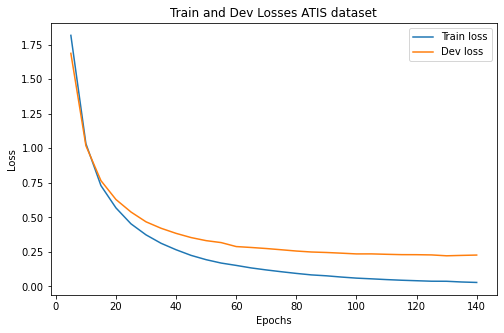

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Dev Losses ATIS dataset')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epochs_ATIS, losses_train_ATIS, label='Train loss')
plt.plot(sampled_epochs_ATIS, losses_dev_ATIS, label='Dev loss')
plt.legend()
plt.show()

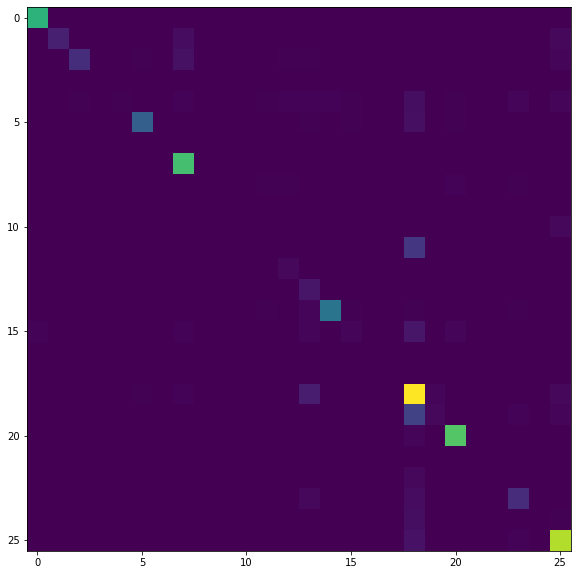

In [ ]:
mp.pyplot.figure(figsize = (10,10))
mp.pyplot.imshow(cm_intent_ATIS, norm = mp.colors.Normalize(vmin = 0, vmax = 255))

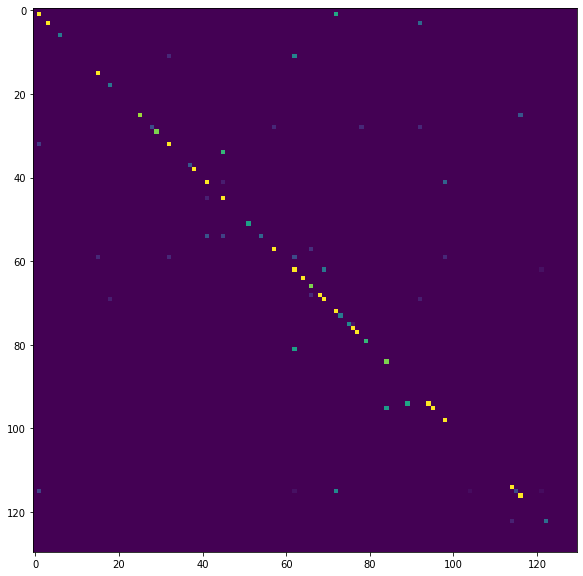

In [ ]:
mp.pyplot.figure(figsize = (10,10))
mp.pyplot.imshow(cm_slot_ATIS, norm = mp.colors.Normalize(vmin = 0, vmax = 255))

#### Snips training

In [38]:
model_baseline_SNIPS = ModelIAS(hid_size, out_slot_SNIPS, out_int_SNIPS, emb_size, vocab_len_SNIPS, bidirectional = False, pad_index=PAD_TOKEN).to(device)
model_baseline_SNIPS.apply(init_weights)

optimizer_SNIPS = optim.Adam(model_baseline_SNIPS.parameters(), lr=lr)

In [ ]:
slots_baseline_SNIPS = []
intents_baseline_SNIPS = []
for i in range(5):
  model_baseline_SNIPS.apply(init_weights)
  results_test_SNIPS, intents_test_SNIPS, sampled_epochs_SNIPS, losses_train_SNIPS, losses_dev_SNIPS, cm_slot, cm_intent = train_model(dev_loader_SNIPS,
                                                                                                                                        train_loader_SNIPS, 
                                                                                                                                        test_loader_SNIPS, 
                                                                                                                                        model_baseline_SNIPS,
                                                                                                                                        lang_SNIPS, 
                                                                                                                                        criterion_intents, 
                                                                                                                                        criterion_slots, 
                                                                                                                                        optimizer_SNIPS)
  print('\nSlot F1: ', round(results_test_SNIPS['total']['f-measure'],3))
  print('Intent Accuracy:', round(intents_test_SNIPS['accuracy'],3))
  cm_slot_SNIPS += cm_slot
  cm_intent_SNIPS += cm_intent
  slots_baseline_SNIPS.append(results_test_SNIPS['total']['f-measure'])
  intents_baseline_SNIPS.append(intents_test_SNIPS['accuracy'])
slots_mean_SNIPS = np.mean(slots_baseline_SNIPS)
slots_std_SNIPS = np.std(slots_baseline_SNIPS)
intents_mean_SNIPS = np.mean(intents_baseline_SNIPS)
intents_std_SNIPS = np.std(intents_baseline_SNIPS)
print('\nSlot F1 mean: ', round(slots_mean_SNIPS,3))
print('Slot F1 standard deviation: ', round(slots_std_SNIPS,3))
print('Intent Accuracy mean:', round(intents_mean_SNIPS,3))
print('Intent Accuracy standard deviation:', round(intents_std_SNIPS,3))

 50%|████▉     | 99/199 [02:57<02:59,  1.79s/it]



Slot F1:  0.811
Intent Accuracy: 0.96


 37%|███▋      | 74/199 [02:20<03:57,  1.90s/it]



Slot F1:  0.816
Intent Accuracy: 0.957


 37%|███▋      | 74/199 [02:07<03:36,  1.73s/it]



Slot F1:  0.812
Intent Accuracy: 0.96


 42%|████▏     | 84/199 [02:23<03:17,  1.71s/it]



Slot F1:  0.828
Intent Accuracy: 0.967


 35%|███▍      | 69/199 [01:58<03:43,  1.72s/it]


Slot F1:  0.827
Intent Accuracy: 0.961

Slot F1 mean:  0.819
Slot F1 standard deviation:  0.007
Intent Accuracy mean: 0.961
Intent Accuracy standard deviation: 0.003


In [43]:
pd_tbl = pd.DataFrame().from_dict({k: v for k, v in sorted(results_test_SNIPS.items(), key=lambda x: x[1]['f-measure'], reverse = True)}, orient='index')
pd_tbl.round(decimals=3)

,precision,recall,f-measure,support
movie_type,1.000,1.000,1.000,33
condition_temperature,1.000,1.000,1.000,23
best_rating,1.000,1.000,1.000,43
facility,1.000,1.000,1.000,3
rating_unit,1.000,1.000,1.000,40
rating_value,0.988,0.988,0.988,80
music_item,0.963,0.990,0.976,104
sort,0.941,1.000,0.970,32
current_location,1.000,0.929,0.963,14
condition_description,1.000,0.929,0.963,28


In [ ]:
intents_test_SNIPS.pop('accuracy')
pd_tbl = pd.DataFrame().from_dict({k: v for k, v in sorted(intents_test_SNIPS.items(), key=lambda x: x[1]['f1-score'], reverse = True)}, orient='index')
pd_tbl.round(decimals=3)

,precision,recall,f1-score,support
RateBook,1.000,1.000,1.000,80
BookRestaurant,0.989,1.000,0.995,92
AddToPlaylist,0.992,0.992,0.992,124
GetWeather,0.954,0.990,0.972,104
macro avg,0.961,0.963,0.962,700
weighted avg,0.962,0.961,0.961,700
PlayMusic,0.913,0.977,0.944,86
SearchScreeningEvent,0.960,0.907,0.933,107
SearchCreativeWork,0.922,0.879,0.900,107


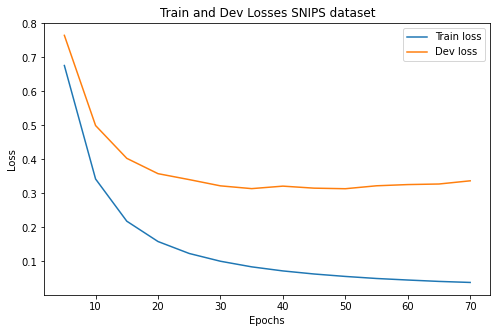

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Dev Losses SNIPS dataset')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epochs_SNIPS, losses_train_SNIPS, label='Train loss')
plt.plot(sampled_epochs_SNIPS, losses_dev_SNIPS, label='Dev loss')
plt.legend()
plt.show()

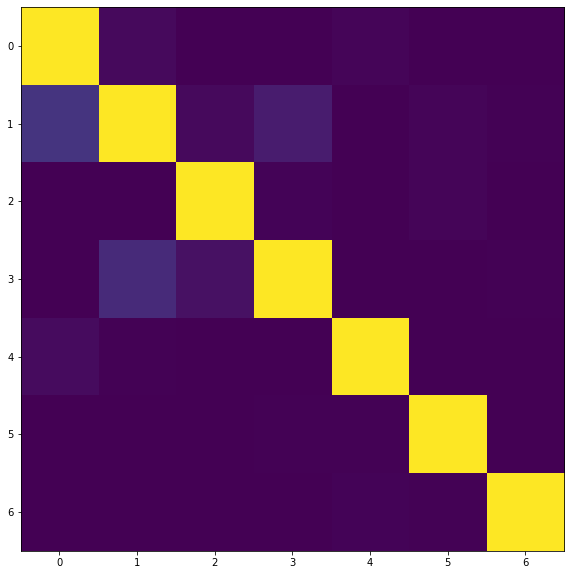

In [ ]:
mp.pyplot.figure(figsize = (10,10))
mp.pyplot.imshow(cm_intent_SNIPS, norm = mp.colors.Normalize(vmin = 0, vmax = 255))

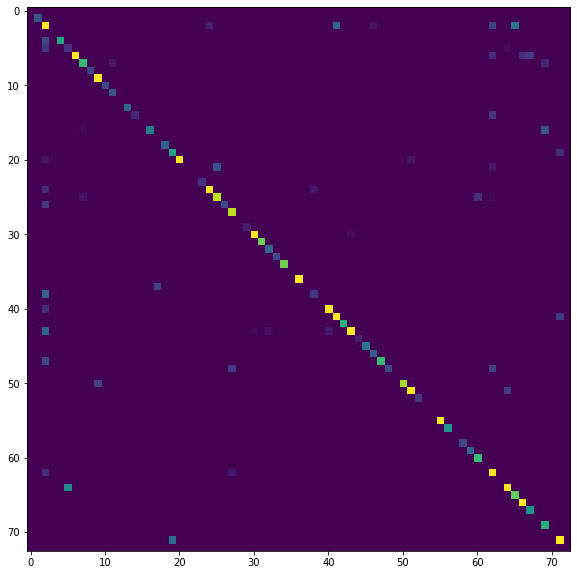

In [ ]:
mp.pyplot.figure(figsize = (10,10))
mp.pyplot.imshow(cm_slot_SNIPS, norm = mp.colors.Normalize(vmin = 0, vmax = 255))

## Second model

The second model is an upgraded version of the baseline seen in lab 10.

The loss is calculated differently with respect to the baseline:

- Baseline:
given the slot task loss, the intent task loss, compute the loss as
    
    $L = loss\_slot + loss\_intent$


- Model 2:
given the slot task loss, the intent task loss, 2 random number $nrandom_1, nrandom_2$ such that $nrandom_1 + nrandom_2 = 1$, compute the loss as

    $L =max(nrandom_1, nrandom_2) * max(loss\_slot, loss\_intent) + min(nrandom_1, nrandom_2 * min(loss\_slot, loss\_intent)$


The early stopping is computed by taking into consideration two different patiences:
-  Patience_f1 (for slot task)
-  Patience_accuracy (for intent task)

They both are initialized with a value = 5 and are decremented by 1 every time the specific performance gets worse.

When both patiences are equal o below 0 ($patience\_f1 <= 0$ and $patience\_acc <= 0$) the training stops.


Lastly the lstm encoder is bidirectional, this way the model is able to encode feature that consider both the direction in the sentence.

In [94]:
from conll import evaluate
import torch.nn.functional as F
from sklearn.metrics import classification_report

def train_loop(data, optimizer, criterion_slots, criterion_intents, model):
    model.train()
    loss_array = []
    slot_loss_array = []
    intent_loss_array = []

    for i,sample in enumerate(data):
        optimizer.zero_grad() # Zeroing the gradient
        slots, intent = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intent, sample['intents'])
        loss_slot = criterion_slots(slots, sample['y_slots'])

        slot_loss_array.append(loss_slot.item())
        intent_loss_array.append(loss_intent.item())

        weight, _ = torch.sort(F.softmax(torch.randn(2), dim=-1))
        #loss = torch.sum(losses*weight)
        loss = loss_intent*weight[0] + loss_slot*weight[1] if loss_intent < loss_slot else loss_intent*weight[1] + loss_slot*weight[0]
        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        # torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  
        optimizer.step() # Update the weights
        
    return loss_array

def eval_loop(data, criterion_slots, criterion_intents, model, lang):
    model.eval()
    loss_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
    with torch.no_grad(): # It used to avoid the creation of computational graph
        total_slot_labels = [x for x in range (len(lang.id2slot))]
        total_intent_labels = [v for k, v in lang.id2intent.items()]
        #Confusion matrices
        cm_slot = np.zeros((len(total_slot_labels), len(total_slot_labels)))
        cm_intent = np.zeros((len(total_intent_labels), len(total_intent_labels)))
        for sample in data:
            slots, intents = model(sample['utterances'], sample['slots_len'])
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])
            #NOTE the loss in evaluation is calculated as the simple sum, because the random weights
            #are used only for training, and the simple loss is a better indicator for the evaluation
            loss = loss_intent + loss_slot 
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            
            ref_int_labels = []
            hyp_int_labels = []

            # Slot inference 
            output_slots = torch.argmax(slots, dim=1)
            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                utterance = [lang.id2word[elem] for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                  tmp_seq.append((utterance[id_el], lang.id2slot[elem]))
                  ref_int_labels.extend(gt_ids[:length])
                  hyp_int_labels.extend(to_decode)

                hyp_slots.append(tmp_seq)

        X = [lang.id2slot[x] for x in ref_int_labels]
        Y = [lang.id2slot[x] for x in hyp_int_labels]
        labels = [lang.id2slot[x] for x in total_slot_labels]

        cm_slot += sklearn.metrics.confusion_matrix(X, Y,labels = labels)
        cm_intent += sklearn.metrics.confusion_matrix(ref_intents, hyp_intents,labels = total_intent_labels)
    
    try:            
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex:
        # Sometimes the model predics a class that is not in REF
        results = None

    #results = sklearn.metrics.f1_score(ref_int_labels, hyp_int_labels, labels = total_slot_labels, average = 'micro')
    #results = sklearn.metrics.f1_score(gt_slots, hyp_slots, average = 'macro')
        
    report_intent = classification_report(ref_intents, hyp_intents, 
                                          zero_division=False, output_dict=True)
    return results, report_intent, loss_array, cm_slot, cm_intent

###Model definition

In [68]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class ModelUpgrade(nn.Module):
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len,bidirectional = True, n_layer=1, pad_index=0):
        super(ModelUpgrade, self).__init__()
        
        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        
        self.utt_encoder = nn.LSTM(emb_size, hid_size, n_layer, bidirectional = bidirectional)
        self.slot_out = nn.Linear(hid_size*2 if bidirectional else hid_size, out_slot)
        self.intent_out = nn.Linear(hid_size, out_int)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, utterance, seq_lengths):
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
        
        # pack_padded_sequence avoid computation over pad tokens reducing the computational cost
        
        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input)
        # Unpack the sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output)
        # Get the last hidden state
        last_hidden = last_hidden[-1,:,:]
        # Compute slot logits
        slots = self.slot_out(utt_encoded)
        # Compute intent logits
        intent = self.intent_out(last_hidden)
        
        # Slot size: seq_len, batch size, calsses 
        slots = slots.permute(1,0,2) # We need this for computing the loss
        # Slot size: batch_size, classes, seq_len
        return slots, intent

###Training

In [92]:
def train_model(dev_loader, train_loader, test_loader, model, lang, criterion_intents, criterion_slots, optimizer):
    from tqdm import tqdm
    n_epochs = 200
    patience_f1 = 5
    patience_acc = 5
    losses_train = []
    losses_dev = []
    sampled_epochs = []
    best_f1 = 0
    best_acc = 0
    for x in tqdm(range(1,n_epochs)):
        loss = train_loop(train_loader, optimizer, criterion_slots, 
                        criterion_intents, model)
        if x % 5 == 0:
          sampled_epochs.append(x)
          losses_train.append(np.asarray(loss).mean())
          results_dev, intent_res, loss_dev, trypl, _ = eval_loop(dev_loader, criterion_slots, 
                                                      criterion_intents, model, lang)
          losses_dev.append(np.asarray(loss_dev).mean())
          if results_dev != None:
            f1 = results_dev['total']['f-measure']
            acc = intent_res['accuracy']
          
            if f1 > best_f1:
              patience_f1 += 1 if patience_f1 < 5 else 0
              best_f1 = f1
            else:
              patience_f1 -= 1
            if acc > best_acc:
              patience_acc += 1 if patience_acc < 5 else 0
              best_acc = acc
            else:
              patience_acc -= 1

            if patience_f1 <= 0 and patience_acc <= 0: # Early stoping with patient
                break # Not nice but it keeps the code clean

    results_test, intent_test, _, cm_slot, cm_intent = eval_loop(test_loader, criterion_slots, 
                                            criterion_intents, model, lang)
    
    return results_test, intent_test, sampled_epochs, losses_train, losses_dev, cm_slot, cm_intent  

In [70]:
import torch.optim as optim

hid_size = 200
emb_size = 300

lr = 0.0001 # learning rate
clip = 5 # Clip the gradient

criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

In [71]:
model_2_ATIS = ModelUpgrade(hid_size, out_slot_ATIS, out_int_ATIS, emb_size, vocab_len_ATIS, bidirectional = True, pad_index=PAD_TOKEN).to(device)
model_2_ATIS.apply(init_weights)

optimizer_ATIS = optim.Adam(model_2_ATIS.parameters(), lr=lr)

In [72]:
model_2_SNIPS = ModelUpgrade(hid_size, out_slot_SNIPS, out_int_SNIPS, emb_size, vocab_len_SNIPS, bidirectional = True, pad_index=PAD_TOKEN).to(device)
model_2_SNIPS.apply(init_weights)

optimizer_SNIPS = optim.Adam(model_2_SNIPS.parameters(), lr=lr)

In [73]:
cm_slot_ATIS, cm_intent_ATIS = initialize_confusion_matrices(lang_ATIS)
cm_slot_SNIPS, cm_intent_SNIPS = initialize_confusion_matrices(lang_SNIPS)

####Atis training

In [ ]:
slots_2_ATIS = []
intents_2_ATIS = []
for i in range(5):
  model_2_ATIS.apply(init_weights)
  results_test_ATIS, intents_test_ATIS, sampled_epochs_ATIS, losses_train_ATIS, losses_dev_ATIS, cm_slot, cm_intent = train_model(dev_loader_ATIS,
                                                                                                                                        train_loader_ATIS, 
                                                                                                                                        test_loader_ATIS, 
                                                                                                                                        model_2_ATIS,
                                                                                                                                        lang_ATIS, 
                                                                                                                                        criterion_intents, 
                                                                                                                                        criterion_slots, 
                                                                                                                                        optimizer_ATIS)
  print('\nSlot F1: ', round(results_test_ATIS['total']['f-measure'],3))
  print('Intent Accuracy:', round(intents_test_ATIS['accuracy'],3))
  cm_slot_ATIS += cm_slot
  cm_intent_ATIS += cm_intent
  slots_2_ATIS.append(results_test_ATIS['total']['f-measure'])
  intents_2_ATIS.append(intents_test_ATIS['accuracy'])
slots_mean_ATIS = np.mean(slots_2_ATIS)
slots_std_ATIS = np.std(slots_2_ATIS)
intents_mean_ATIS = np.mean(intents_2_ATIS)
intents_std_ATIS = np.std(intents_2_ATIS)
print('\nSlot F1 mean: ', round(slots_mean_ATIS,3))
print('Slot F1 standard deviation: ', round(slots_std_ATIS,3))
print('Intent Accuracy mean:', round(intents_mean_ATIS,3))
print('Intent Accuracy standard deviation:', round(intents_std_ATIS,3))

 90%|████████▉ | 179/199 [40:10<04:29, 13.47s/it]



Slot F1:  0.939
Intent Accuracy: 0.954


 82%|████████▏ | 164/199 [35:16<07:31, 12.90s/it]



Slot F1:  0.945
Intent Accuracy: 0.955


 67%|██████▋   | 134/199 [28:51<13:59, 12.92s/it]



Slot F1:  0.944
Intent Accuracy: 0.956


 65%|██████▍   | 129/199 [27:25<14:53, 12.76s/it]



Slot F1:  0.945
Intent Accuracy: 0.957


 70%|██████▉   | 139/199 [29:35<12:46, 12.78s/it]



Slot F1:  0.947
Intent Accuracy: 0.959

Slot F1 mean:  0.944
Slot F1 standard deviation:  0.003
Intent Accuracy mean: 0.956
Intent Accuracy standard deviation: 0.002


In [ ]:
pd_tbl = pd.DataFrame().from_dict({k: v for k, v in sorted(results_test_ATIS.items(), key=lambda x: x[1]['f-measure'], reverse = True)}, orient='index')
pd_tbl.round(decimals=3)

,precision,recall,f-measure,support
flight_days,1.0,1.0,1.0,10
state_code,1.0,1.0,1.0,1
depart_time.period_mod,1.0,1.0,1.0,5
flight_stop,1.0,1.0,1.0,21
toloc.state_code,1.0,1.0,1.0,18
...,...,...,...,...
return_date.day_name,1.0,0.0,0.0,2
state_name,1.0,0.0,0.0,9
meal_code,1.0,0.0,0.0,1
flight,1.0,0.0,0.0,1


In [ ]:
intents_test_ATIS.pop('accuracy')
pd_tbl = pd.DataFrame().from_dict({k: v for k, v in sorted(intents_test_ATIS.items(), key=lambda x: x[1]['f1-score'], reverse = True)}, orient='index')
pd_tbl.round(decimals=3)

,precision,recall,f1-score,support
distance,1.000,1.000,1.000,10
flight_time,1.000,1.000,1.000,1
airline,0.974,1.000,0.987,38
abbreviation,0.971,1.000,0.985,33
flight,0.966,0.989,0.977,632
ground_service,0.972,0.972,0.972,36
weighted avg,0.956,0.959,0.953,893
capacity,1.000,0.905,0.950,21
airfare,0.922,0.979,0.949,48
airport,0.941,0.889,0.914,18


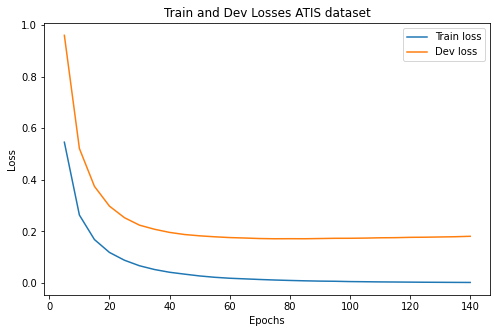

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Dev Losses ATIS dataset')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epochs_ATIS, losses_train_ATIS, label='Train loss')
plt.plot(sampled_epochs_ATIS, losses_dev_ATIS, label='Dev loss')
plt.legend()
plt.show()

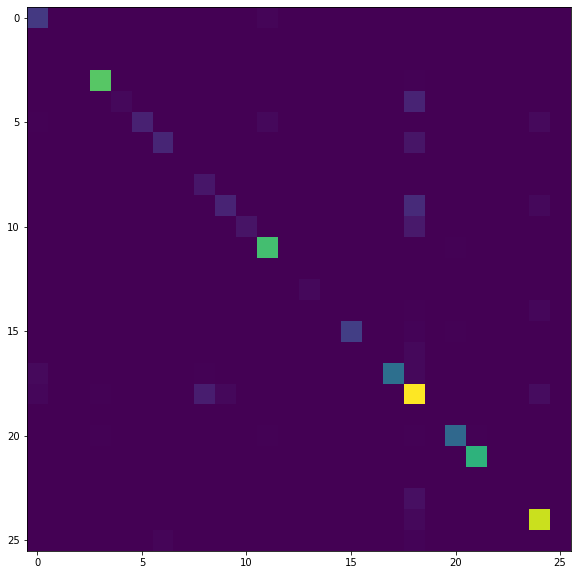

In [ ]:
mp.pyplot.figure(figsize = (10,10))
mp.pyplot.imshow(cm_intent_ATIS, norm = mp.colors.Normalize(vmin = 0, vmax = 255))

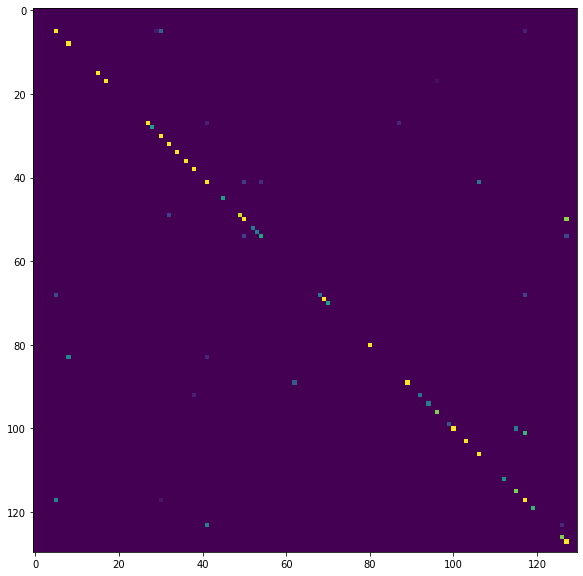

In [ ]:
mp.pyplot.figure(figsize = (10,10))
mp.pyplot.imshow(cm_slot_ATIS, norm = mp.colors.Normalize(vmin = 0, vmax = 255))

####Snips training

In [ ]:
slots_2_SNIPS = []
intents_2_SNIPS = []
for i in range(5):
  model_2_SNIPS.apply(init_weights)
  results_test_SNIPS, intents_test_SNIPS, sampled_epochs_SNIPS, losses_train_SNIPS, losses_dev_SNIPS, cm_slot, cm_intent = train_model(dev_loader_SNIPS,
                                                                                                                                        train_loader_SNIPS, 
                                                                                                                                        test_loader_SNIPS, 
                                                                                                                                        model_2_SNIPS,
                                                                                                                                        lang_SNIPS, 
                                                                                                                                        criterion_intents, 
                                                                                                                                        criterion_slots, 
                                                                                                                                        optimizer_SNIPS)
  print('\nSlot F1: ', round(results_test_SNIPS['total']['f-measure'],3))
  print('Intent Accuracy:', round(intents_test_SNIPS['accuracy'],3))
  cm_slot_SNIPS += cm_slot
  cm_intent_SNIPS += cm_intent
  slots_2_SNIPS.append(results_test_SNIPS['total']['f-measure'])
  intents_2_SNIPS.append(intents_test_SNIPS['accuracy'])
slots_mean_SNIPS = np.mean(slots_2_SNIPS)
slots_std_SNIPS = np.std(slots_2_SNIPS)
intents_mean_SNIPS = np.mean(intents_2_SNIPS)
intents_std_SNIPS = np.std(intents_2_SNIPS)
print('\nSlot F1 mean: ', round(slots_mean_SNIPS,3))
print('Slot F1 standard deviation: ', round(slots_std_SNIPS,3))
print('Intent Accuracy mean:', round(intents_mean_SNIPS,3))
print('Intent Accuracy standard deviation:', round(intents_std_SNIPS,3))

 87%|████████▋ | 174/199 [06:16<00:54,  2.16s/it]



Slot F1:  0.869
Intent Accuracy: 0.957


 42%|████▏     | 84/199 [03:00<04:07,  2.15s/it]



Slot F1:  0.875
Intent Accuracy: 0.96


 50%|████▉     | 99/199 [03:32<03:34,  2.15s/it]



Slot F1:  0.881
Intent Accuracy: 0.969


 40%|███▉      | 79/199 [02:52<04:22,  2.19s/it]



Slot F1:  0.883
Intent Accuracy: 0.957


 45%|████▍     | 89/199 [03:11<03:56,  2.15s/it]


Slot F1:  0.878
Intent Accuracy: 0.961

Slot F1 mean:  0.877
Slot F1 standard deviation:  0.005
Intent Accuracy mean: 0.961
Intent Accuracy standard deviation: 0.004


In [ ]:
pd_tbl = pd.DataFrame().from_dict({k: v for k, v in sorted(results_test_SNIPS.items(), key=lambda x: x[1]['f-measure'], reverse = True)}, orient='index')
pd_tbl.round(decimals=3)

,precision,recall,f-measure,support
object_location_type,1.000,1.000,1.000,22
current_location,1.000,1.000,1.000,14
party_size_number,1.000,1.000,1.000,50
rating_unit,1.000,1.000,1.000,40
condition_temperature,1.000,1.000,1.000,23
facility,1.000,1.000,1.000,3
condition_description,1.000,1.000,1.000,28
movie_type,1.000,1.000,1.000,33
best_rating,1.000,1.000,1.000,43
restaurant_type,1.000,0.985,0.992,65


In [ ]:
intents_test_SNIPS.pop('accuracy')
pd_tbl = pd.DataFrame().from_dict({k: v for k, v in sorted(intents_test_SNIPS.items(), key=lambda x: x[1]['f1-score'], reverse = True)}, orient='index')
pd_tbl.round(decimals=3)

,precision,recall,f1-score,support
AddToPlaylist,1.000,1.000,1.000,124
RateBook,0.988,1.000,0.994,80
GetWeather,0.990,0.990,0.990,104
BookRestaurant,0.989,0.989,0.989,92
macro avg,0.962,0.962,0.962,700
weighted avg,0.962,0.961,0.962,700
PlayMusic,0.941,0.930,0.936,86
SearchScreeningEvent,0.951,0.916,0.933,107
SearchCreativeWork,0.874,0.907,0.890,107


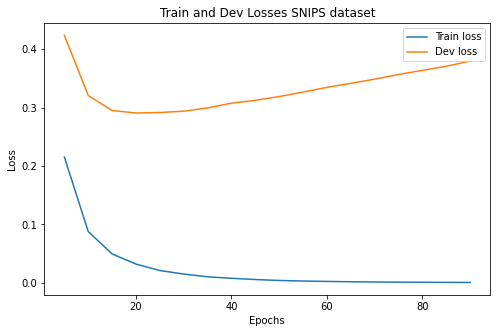

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Dev Losses SNIPS dataset')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epochs_SNIPS, losses_train_SNIPS, label='Train loss')
plt.plot(sampled_epochs_SNIPS, losses_dev_SNIPS, label='Dev loss')
plt.legend()
plt.show()

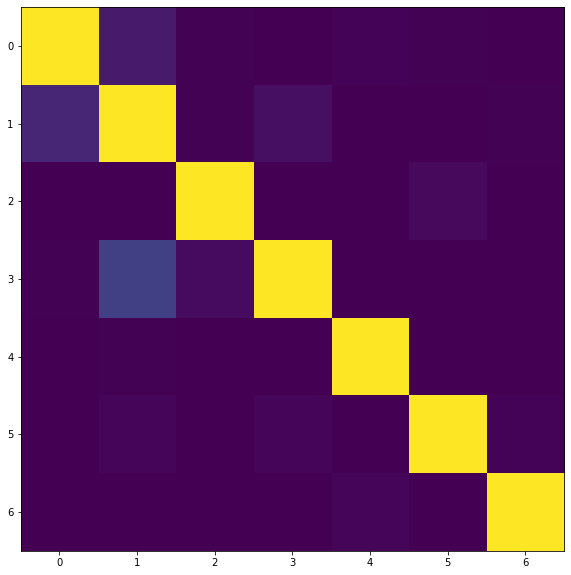

In [ ]:
mp.pyplot.figure(figsize = (10,10))
mp.pyplot.imshow(cm_intent_SNIPS, norm = mp.colors.Normalize(vmin = 0, vmax = 255))

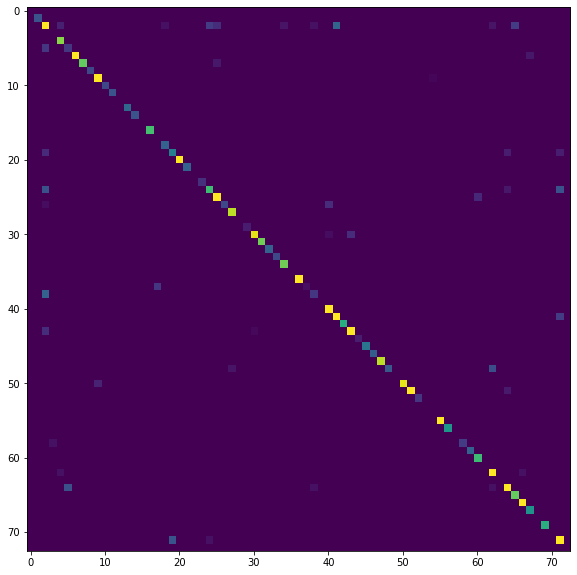

In [ ]:
mp.pyplot.figure(figsize = (10,10))
mp.pyplot.imshow(cm_slot_SNIPS, norm = mp.colors.Normalize(vmin = 0, vmax = 255))

## Third model

Implementation of the paper ***A Bi-model based RNN Semantic Frame Parsing Model for Intent Detection and Slot Filling***    
[Paper link](https://aclanthology.org/N18-2050.pdf)


---


Most of the approaches use one (joint) NN based model (including encoderdecoder structure) to model two tasks, hence may not fully take advantage of the crossimpact between them. In this paper, new
Bi-model based RNN semantic frame parsing network structures are designed to perform the intent detection and slot filling tasks
jointly, by considering their cross-impact to
each other using two correlated bidirectional
LSTMs.


---
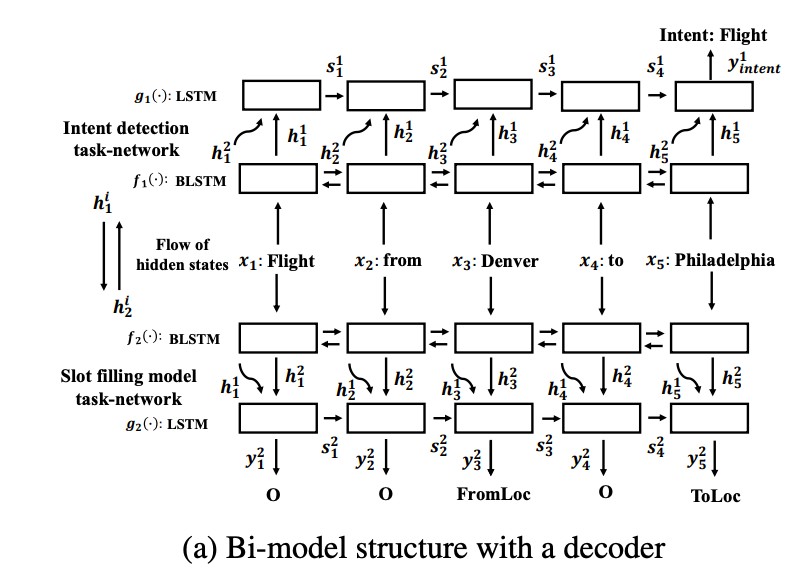

In the proposed model there are two inter-connected bidirectional LSTMs (BLSTMs) in the structure, one
is for intent detection and the other is for slot filling. Each BLSTM reads in the input utterance sequences $(x_1, x_2, · · · , x_n)$ forward and backward,
and generates two sequences of hidden states hft
and hbt. A concatenation of hft and hbt forms a final BLSTM state $ht = [hf_t, hb_t]$ at time step t.

Hence, the bidirectional LSTM $f_i(·)$ generates a
sequence of hidden states $(h^i_1, h^i_2, · · · , h^i_n)$, where
$i = 1$ corresponds the network for intent detection
task and $i = 2$ is for the slot filling task.
In order to detect intent, hidden state $h^1_t$ is combined together with $h^2_t$
from the other bidirectional LSTM.
The difference in slot filling 
is that there will be an output $y^2_t$
at each time step
t for $g_2(·)$, as it is a sequence labeling problem.

The authors did not provide an implementation of the paper, the model structure has been taken from an implementation available on this [github repo](https://github.com/ray075hl/Bi-Model-Intent-And-Slot) and it has been adapted for this project, the training and evaluation has been coded from scratch.


---


After trying many different strategies for the early stopping, the two best candidates were the one used in the second model ($patience\_f1 <= 0$ and $patience\_acc <= 0$) and a new one that considers them more jointly stopping when the sum of the two patience reaches the 0 threshold ($patience\_f1 +  patience\_acc <= 0$).
The two have shown very similar results, I decided to keep the first one because it pushed the training a bit further.

### Training and evaluation loop

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
from operator import length_hint
import sklearn
from conll import evaluate
import torch.nn.functional as F
from sklearn.metrics import classification_report
def train_loop(data, optimizer_slots, optimizer_intents, criterion_slots, criterion_intents, model_slots, model_intents):
    model_slots.train()
    model_intents.train()
    loss_array = []
    slot_loss_array = []
    intent_loss_array = []

    for i,sample in enumerate(data):
        #mask = make_mask(sample['slots_len'], model_slots.label_size).to(device)
        optimizer_slots.zero_grad() # Zeroing the gradient
        optimizer_intents.zero_grad() # Zeroing the gradient

        #slot encoder output -> go into intent decoder
        hs = model_slots.enc(sample['utterances'])
        model_slots.share_memory = hs.clone()
        #intent encoder output -> go into slot decoder
        hi = model_intents.enc(sample['utterances'])
        model_intents.share_memory = hi.clone()

        slot_logits = model_slots.dec(hs, model_intents.share_memory.detach(), sample['slots_len'], sample['heads'], sample['deps'])
        slot_logits = F.log_softmax(slot_logits, dim = 1)

        loss_slot = criterion_slots(slot_logits, sample['y_slots']) 
        slot_loss_array.append(loss_slot.item())
        loss_slot.backward()

        nn.utils.clip_grad_norm_(model_slots.parameters(), 5.0)
        optimizer_slots.step()

        intent_logits = F.log_softmax(model_intents.dec(hi, model_slots.share_memory.detach(),sample['slots_len']), dim = 1)
        loss_intent = criterion_intents(intent_logits, sample['intents'])
        intent_loss_array.append(loss_intent.item())
        loss_intent.backward()

        nn.utils.clip_grad_norm_(model_intents.parameters(), 5.0)
        optimizer_intents.step()
        
    return intent_loss_array, slot_loss_array

def eval_loop(data, criterion_slots, criterion_intents, model_slots, model_intents, lang):
    model_slots.eval()
    model_intents.eval()
    slot_loss_array = []
    intent_loss_array = []

    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
    with torch.no_grad(): # It used to avoid the creation of computational graph
        #labels list to create confusion matrices
        total_slot_labels = [x for x in range (len(lang.id2slot))]
        total_intent_labels = [v for k, v in lang.id2intent.items()]
        #temporary consusion matrices initialization
        cm_slot = np.zeros((len(total_slot_labels), len(total_slot_labels)))
        cm_intent = np.zeros((len(total_intent_labels), len(total_intent_labels)))

        for sample in data:

            hs = model_slots.enc(sample['utterances'])
            model_slots.share_memory = hs.clone()
            hi = model_intents.enc(sample['utterances'])
            model_intents.share_memory = hi.clone()

            slot_logits = model_slots.dec(hs, model_intents.share_memory.detach(), sample['slots_len'], sample['heads'], sample['deps'])
            slot_logits = F.log_softmax(slot_logits, dim = 1)
            
            loss_slot = criterion_slots(slot_logits, sample['y_slots']) 
            slot_loss_array.append(loss_slot.item())

            intent_logits = model_intents.dec(hi, model_slots.share_memory.detach(),sample['slots_len'])
            intent_logits = F.log_softmax(intent_logits, dim=1)
            loss_intents = criterion_intents(intent_logits, sample['intents'])
            intent_loss_array.append(loss_intents.item())

            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intent_logits, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            
            # Slot inference 
            output_slots = torch.argmax(slot_logits, dim=1)

            ref_int_labels = []
            hyp_int_labels = []
            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                utterance = [lang.id2word[elem] for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                  tmp_seq.append((utterance[id_el], lang.id2slot[elem]) if elem != 0 else (utterance[id_el], 'O'))
                  ref_int_labels.extend(gt_ids[:length])
                  hyp_int_labels.extend(to_decode)
                hyp_slots.append(tmp_seq)
            
            #create lists of hyp and ref for slot confusion matrix
            X = [lang.id2slot[x] for x in ref_int_labels]
            Y = [lang.id2slot[x] for x in hyp_int_labels]
            labels = [lang.id2slot[x] for x in total_slot_labels]

            #summing previous confusion matrix with new
            cm_slot += sklearn.metrics.confusion_matrix(X, Y,labels = labels)
            cm_intent += sklearn.metrics.confusion_matrix(ref_intents, hyp_intents,labels = total_intent_labels)

    try:            
      results = evaluate(ref_slots, hyp_slots)
    except Exception as ex:
        # Sometimes the model predics a class that is not in REF
      results = None

    #results = sklearn.metrics.f1_score(ref_int_labels, hyp_int_labels, labels = total_slot_labels, average = 'micro')
    #results = sklearn.metrics.f1_score(gt_slots, hyp_slots, average = 'macro')
        
    report_intent = classification_report(ref_intents, hyp_intents, 
                                          zero_division=False, output_dict=True)
    
    return results, report_intent, intent_loss_array, slot_loss_array, cm_slot, cm_intent

### Model definition

**Slot filling encoder**

In [ ]:
class slot_enc(nn.Module):
    def __init__(self, embedding_size, lstm_hidden_size, vocab_size):
        super(slot_enc, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=PAD_TOKEN).to(device)
        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size=lstm_hidden_size, num_layers=2,\
                            bidirectional= True, batch_first=True, dropout=DROPOUT)

    def forward(self, x):
        x = self.embedding(x)
        x = F.dropout(x, DROPOUT)       
        x, _ = self.lstm(x)
        x = F.dropout(x, DROPOUT)
        return x 

**Slot filling decoder**

In [ ]:
class slot_dec(nn.Module):
    def __init__(self, lstm_hidden_size, label_size):
        super(slot_dec, self).__init__()
        self.lstm = nn.LSTM(input_size=lstm_hidden_size*5, hidden_size=lstm_hidden_size, num_layers=2, dropout = DROPOUT)
        self.fc = nn.Linear(lstm_hidden_size+2, label_size)
        self.hidden_size = lstm_hidden_size

    def forward(self, x, hi, real_len, heads, deps):
        batch = x.size(0)
        length = x.size(1)
        dec_init_out = torch.zeros(batch, 1, self.hidden_size).to(device)
        hidden_state = (torch.zeros(2, 1, self.hidden_size).to(device), \
                        torch.zeros(2, 1, self.hidden_size).to(device))
        x = torch.cat((x, hi), dim=-1)

        x = x.transpose(1, 0)  # 50 x batch x feature_size
        x = F.dropout(x, DROPOUT)
        all_out = []
        for i in range(length):
            if i == 0:
                out, hidden_state = self.lstm(torch.cat((x[i].unsqueeze(1), dec_init_out), dim=-1), hidden_state)
            else:
                out, hidden_state = self.lstm(torch.cat((x[i].unsqueeze(1), out), dim=-1), hidden_state)
            all_out.append(out)
        output = torch.cat(all_out, dim=1) # 50 x batch x feature_size

        if(heads.shape[1] < output.shape[1]):
          diff = output.shape[1] - heads.shape[1]
          pad = torch.zeros((output.shape[0],diff)).to(device)
          heads = torch.cat((heads, pad), dim = -1)
          deps = torch.cat((deps, pad), dim = -1)
        if(heads.shape[1] > output.shape[1]):
          diff = heads.shape[1] - output.shape[1]
          heads = heads[:,:-diff]
          deps = deps[:,:-diff]
        output = torch.cat((output, heads.unsqueeze(2), deps.unsqueeze(2)), dim = -1)
        # for i, batch in enumerate(output):
        #     for j,word in enumerate(batch):
        #         print(heads[i][j])
        #         word = torch.cat((word, heads[i][j], deps[i][j]))

        x = F.dropout(x, DROPOUT)
        res = self.fc(output)
        res = res.permute(0,2,1)
        return res 

**Intent classification encoder**

In [ ]:
class intent_enc(nn.Module):
    def __init__(self, embedding_size, lstm_hidden_size, vocab_size):
        super(intent_enc, self).__init__()
		
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=PAD_TOKEN).to(device)
        # self.embedding.weight.data.uniform_(-1.0, 1.0)
        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size= lstm_hidden_size, num_layers=2,\
                            bidirectional= True, batch_first=True, dropout=DROPOUT)
    
    def forward(self, x):
        x = self.embedding(x)
        x = F.dropout(x, DROPOUT)
        x, _ = self.lstm(x)
        x = F.dropout(x, DROPOUT)
        return x

**Intent classification decoder**

In [ ]:
class intent_dec(nn.Module):
    def __init__(self, lstm_hidden_size, label_size):
        super(intent_dec, self).__init__()
        self.lstm = nn.LSTM(input_size=lstm_hidden_size*4, hidden_size=lstm_hidden_size, batch_first=True, num_layers=2, dropout = DROPOUT)
        self.fc = nn.Linear(lstm_hidden_size, label_size)
        
    def forward(self, x, hs, real_len):
        batch = x.size()[0]
        real_len = real_len.to(device)
        x = torch.cat((x, hs), dim=-1)
        x = F.dropout(x, DROPOUT)
        x, _ = self.lstm(x)
        x = F.dropout(x, DROPOUT)

        index = torch.arange(batch).long().to(device)
        state = x[index, real_len-1, :]
        
        res = self.fc(state.squeeze())
        return res

**Whole intent classification model**

In [ ]:
class Intent(nn.Module):
    def __init__(self, embedding_size, lstm_hidden_size, batch, max_len, label_size, vocab_len):
        super(Intent, self).__init__()
        self.label_size = label_size
        self.enc = intent_enc(embedding_size, lstm_hidden_size, vocab_len).to(device)
        self.dec = intent_dec(lstm_hidden_size, label_size).to(device)
        self.share_memory = torch.zeros(batch, max_len, lstm_hidden_size * 2).to(device)

**Whole slot filling model**

In [ ]:
class Slot(nn.Module):
    def __init__(self, embedding_size, lstm_hidden_size, batch, max_len, label_size, vocab_len):
        super(Slot, self).__init__()
        self.label_size = label_size
        self.enc = slot_enc(embedding_size, lstm_hidden_size, vocab_len).to(device)
        self.dec = slot_dec(lstm_hidden_size, label_size).to(device)
        self.share_memory = torch.zeros(batch, max_len, lstm_hidden_size * 2).to(device)

### Training

In [ ]:
def train_BI_model(dev_loader, train_loader, test_loader, model_slots, model_intents, lang, criterion_slots, criterion_intents, optimizer_slots, optimizer_intents):
    from tqdm import tqdm
    n_epochs = 300
    patience_f1 = 5
    patience_acc = 5
    intent_losses_train = []
    slot_losses_train = []
    intent_losses_dev = []
    slot_losses_dev = []
    sampled_epochs = []
    best_f1 = 0
    best_acc = 0
    for x in tqdm(range(1,n_epochs)):
        intent_loss_array, slot_loss_array = train_loop(train_loader, optimizer_slots, optimizer_intents, criterion_slots, 
                        criterion_intents, model_slots, model_intents)
        if x % 5 == 0:
          sampled_epochs.append(x)
          intent_losses_train.append(np.asarray(intent_loss_array).mean())
          slot_losses_train.append(np.asarray(slot_loss_array).mean())

          results_dev, intent_res, loss_intent, loss_slot, _, _ = eval_loop(dev_loader, criterion_slots, 
                                                      criterion_intents, model_slots, model_intents, lang)
          intent_losses_dev.append(np.asarray(loss_intent).mean())
          slot_losses_dev.append(np.asarray(loss_slot).mean())

          if results_dev != None:
            f1 = results_dev['total']['f-measure']
            acc = intent_res['accuracy']
          
            if f1 >= best_f1:
              patience_f1 += 1 if patience_f1 < 5 else 0
              best_f1 = f1
            else:
              patience_f1 -= 1
            if acc >= best_acc:
              patience_acc += 1 if patience_acc < 5 else 0
              best_acc = acc
            else:
              patience_acc -= 1

            if patience_f1 <= 0  and patience_acc <= 0: # Early stoping with patience
                break # Not nice but it keeps the code clean

    results_test, intent_test, _, _, cm_slot, cm_intent = eval_loop(test_loader, criterion_slots, 
                                            criterion_intents, model_slots, model_intents, lang)
    return results_test, intent_test, sampled_epochs, intent_losses_train,slot_losses_train, intent_losses_dev, slot_losses_dev, cm_slot, cm_intent
    

In [ ]:
max_len = 50
batch = 64
learning_rate_slot = 0.00015
learning_rate_intent = 0.0001
DROPOUT = 0.2 # 0.2, 0.3, 0.4


hid_size = 200
emb_size = 300

criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

In [ ]:
slot_model_ATIS = Slot(emb_size,hid_size, batch, max_len, out_slot_ATIS, vocab_len_ATIS).to(device)
intent_model_ATIS = Intent(emb_size,hid_size, batch, max_len, out_int_ATIS, vocab_len_ATIS).to(device)

slot_model_ATIS.apply(init_weights)
intent_model_ATIS.apply(init_weights)

slot_optimizer_ATIS = optim.Adam(slot_model_ATIS.parameters(), lr=learning_rate_slot)
intent_optimizer_ATIS = optim.Adam(intent_model_ATIS.parameters(), lr=learning_rate_intent)

In [ ]:
slot_model_SNIPS = Slot(emb_size,hid_size, batch, max_len, out_slot_SNIPS, vocab_len_SNIPS).to(device)
intent_model_SNIPS = Intent(emb_size,hid_size, batch, max_len, out_int_SNIPS, vocab_len_SNIPS).to(device)

slot_model_SNIPS.apply(init_weights)
intent_model_SNIPS.apply(init_weights)

slot_optimizer_SNIPS = optim.Adam(slot_model_SNIPS.parameters(), lr=learning_rate_slot)
intent_optimizer_SNIPS = optim.Adam(intent_model_SNIPS.parameters(), lr=learning_rate_intent)

In [ ]:
cm_slot_ATIS, cm_intent_ATIS = initialize_confusion_matrices(lang_ATIS)
cm_slot_SNIPS, cm_intent_SNIPS = initialize_confusion_matrices(lang_SNIPS)

#### Atis training

In [ ]:
slot_model_ATIS.apply(init_weights)
intent_model_ATIS.apply(init_weights)
results_test_ATIS, intents_test_ATIS, sampled_epochs_ATIS, intent_losses_train_ATIS, slot_losses_train_ATIS, intent_losses_dev_ATIS, slot_losses_dev_ATIS, cm_slot_ATIS, cm_intent_ATIS = train_BI_model(dev_loader_ATIS,
                                                                                                                                                                                                train_loader_ATIS, 
                                                                                                                                                                                                test_loader_ATIS, 
                                                                                                                                                                                                slot_model_ATIS,
                                                                                                                                                                                                intent_model_ATIS,
                                                                                                                                                                                                lang_ATIS, 
                                                                                                                                                                                                criterion_intents, 
                                                                                                                                                                                                criterion_slots, 
                                                                                                                                                                                                slot_optimizer_ATIS,
                                                                                                                                                                                                intent_optimizer_ATIS)
print('\nSlot F1: ', round(results_test_ATIS['total']['f-measure'],3))
print('Intent Accuracy:', round(intents_test_ATIS['accuracy'],3))

  3%|▎         | 5/199 [01:35<1:01:23, 18.98s/it]

f1: 0
accuracy: 0.7370184254606366


  5%|▌         | 10/199 [03:07<58:32, 18.59s/it]

f1: 0
accuracy: 0.8425460636515912


  8%|▊         | 15/199 [04:39<57:05, 18.62s/it]

f1: 0.11820534943917171
accuracy: 0.8743718592964824


 10%|█         | 20/199 [06:12<56:06, 18.81s/it]

f1: 0.3924993578217313
accuracy: 0.88107202680067


 13%|█▎        | 25/199 [07:45<54:20, 18.74s/it]

f1: 0.4000000000000001
accuracy: 0.914572864321608


 15%|█▌        | 30/199 [09:17<52:59, 18.81s/it]

f1: 0.4856567689984902
accuracy: 0.9262981574539364


 18%|█▊        | 35/199 [10:51<51:38, 18.89s/it]

f1: 0.538558786346397
accuracy: 0.9463986599664992


 20%|██        | 40/199 [12:24<50:09, 18.93s/it]

f1: 0.6112224448897796
accuracy: 0.9514237855946399


 23%|██▎       | 45/199 [13:57<48:19, 18.83s/it]

f1: 0.6465603190428715
accuracy: 0.9547738693467337


 25%|██▌       | 50/199 [15:29<46:27, 18.71s/it]

f1: 0.6847070506454817
accuracy: 0.9597989949748744


 28%|██▊       | 55/199 [17:01<45:01, 18.76s/it]

f1: 0.7028360049321825
accuracy: 0.9581239530988275


 30%|███       | 60/199 [18:32<42:47, 18.47s/it]

f1: 0.7313947757516017
accuracy: 0.9530988274706867


 33%|███▎      | 65/199 [20:05<41:22, 18.52s/it]

f1: 0.7522255192878339
accuracy: 0.9597989949748744


 35%|███▌      | 70/199 [21:36<39:50, 18.53s/it]

f1: 0.7716691431401683
accuracy: 0.9581239530988275


 38%|███▊      | 75/199 [23:09<38:43, 18.73s/it]

f1: 0.7938629052214797
accuracy: 0.9631490787269682


 40%|████      | 80/199 [24:40<36:43, 18.52s/it]

f1: 0.8075974346324617
accuracy: 0.9597989949748744


 43%|████▎     | 85/199 [26:13<35:32, 18.71s/it]

f1: 0.83308568598316
accuracy: 0.9614740368509213


 45%|████▌     | 90/199 [27:46<34:04, 18.76s/it]

f1: 0.8619662363455809
accuracy: 0.9681742043551089


 48%|████▊     | 95/199 [29:18<32:26, 18.72s/it]

f1: 0.8782306163021869
accuracy: 0.9681742043551089


 50%|█████     | 100/199 [30:49<30:27, 18.46s/it]

f1: 0.8847398556136421
accuracy: 0.9698492462311558


 53%|█████▎    | 105/199 [32:23<29:28, 18.82s/it]

f1: 0.8979591836734695
accuracy: 0.9731993299832495


 55%|█████▌    | 110/199 [33:55<27:44, 18.70s/it]

f1: 0.9030815109343937
accuracy: 0.9731993299832495


 58%|█████▊    | 115/199 [35:27<26:08, 18.67s/it]

f1: 0.9104477611940298
accuracy: 0.9681742043551089


 60%|██████    | 120/199 [37:00<24:40, 18.74s/it]

f1: 0.9146128951954196
accuracy: 0.9698492462311558


 63%|██████▎   | 125/199 [38:31<22:47, 18.48s/it]

f1: 0.9184079601990051
accuracy: 0.9715242881072027


 65%|██████▌   | 130/199 [40:03<21:26, 18.64s/it]

f1: 0.9375936095856214
accuracy: 0.9731993299832495


 68%|██████▊   | 135/199 [41:35<19:39, 18.43s/it]

f1: 0.9347609561752989
accuracy: 0.9698492462311558


 70%|███████   | 140/199 [43:06<18:11, 18.51s/it]

f1: 0.9419386992275105
accuracy: 0.9731993299832495


 73%|███████▎  | 145/199 [44:39<16:52, 18.74s/it]

f1: 0.9449838187702264
accuracy: 0.964824120603015


 75%|███████▌  | 150/199 [46:10<15:09, 18.56s/it]

f1: 0.9523571963083063
accuracy: 0.966499162479062


 78%|███████▊  | 155/199 [47:43<13:50, 18.87s/it]

f1: 0.9567824131901075
accuracy: 0.9715242881072027


 80%|████████  | 160/199 [49:15<12:08, 18.67s/it]

f1: 0.9580209895052475
accuracy: 0.9731993299832495


 83%|████████▎ | 165/199 [50:47<10:31, 18.57s/it]

f1: 0.9571072319201995
accuracy: 0.9731993299832495


 85%|████████▌ | 170/199 [52:20<09:04, 18.76s/it]

f1: 0.9541147132169576
accuracy: 0.9715242881072027


 88%|████████▊ | 175/199 [53:51<07:21, 18.40s/it]

f1: 0.9585
accuracy: 0.9698492462311558


 90%|█████████ | 180/199 [55:23<05:53, 18.62s/it]

f1: 0.9587396849212303
accuracy: 0.966499162479062


 93%|█████████▎| 185/199 [56:55<04:20, 18.64s/it]

f1: 0.9602400600150037
accuracy: 0.966499162479062


 95%|█████████▌| 190/199 [58:26<02:46, 18.54s/it]

f1: 0.960759810047488
accuracy: 0.9698492462311558


 98%|█████████▊| 195/199 [59:58<01:14, 18.65s/it]

f1: 0.9645177411294354
accuracy: 0.9731993299832495


100%|██████████| 199/199 [1:01:10<00:00, 18.45s/it]



Slot F1:  0.93
Intent Accuracy: 0.947


In [ ]:
pd_tbl = pd.DataFrame().from_dict({k: v for k, v in sorted(results_test_ATIS.items(), key=lambda x: x[1]['f-measure'], reverse = True)}, orient='index')
pd_tbl.round(decimals=3)

,precision,recall,f-measure,support
state_code,1.000,1.000,1.000,1
arrive_date.date_relative,1.000,1.000,1.000,2
stoploc.city_name,1.000,1.000,1.000,20
fromloc.state_code,1.000,1.000,1.000,23
fromloc.city_name,0.978,0.999,0.988,704
...,...,...,...,...
return_date.day_number,0.000,0.000,0.000,0
period_of_day,1.000,0.000,0.000,4
return_date.date_relative,0.000,0.000,0.000,3
stoploc.state_code,0.000,0.000,0.000,0


In [ ]:
intents_test_ATIS.pop('accuracy')
pd_tbl = pd.DataFrame().from_dict({k: v for k, v in sorted(intents_test_ATIS.items(), key=lambda x: x[1]['f1-score'], reverse = True)}, orient='index')
pd_tbl.round(decimals=3)

,precision,recall,f1-score,support
flight_time,1.000,1.000,1.000,1
abbreviation,1.000,0.970,0.985,33
flight,0.972,0.987,0.980,632
ground_service,0.972,0.972,0.972,36
airfare,0.923,1.000,0.960,48
airline,0.905,1.000,0.950,38
weighted avg,0.939,0.947,0.941,893
capacity,0.947,0.857,0.900,21
distance,1.000,0.800,0.889,10
airport,0.889,0.889,0.889,18


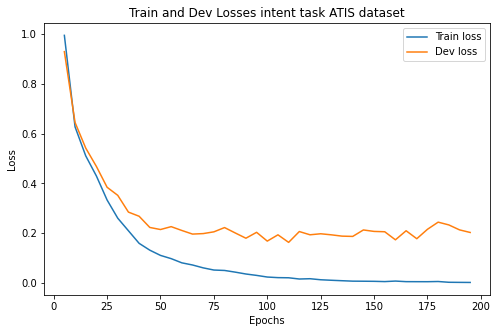

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Dev Losses intent task ATIS dataset')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epochs_ATIS, intent_losses_train_ATIS, label='Train loss')
plt.plot(sampled_epochs_ATIS, intent_losses_dev_ATIS, label='Dev loss')
plt.legend()
plt.show()

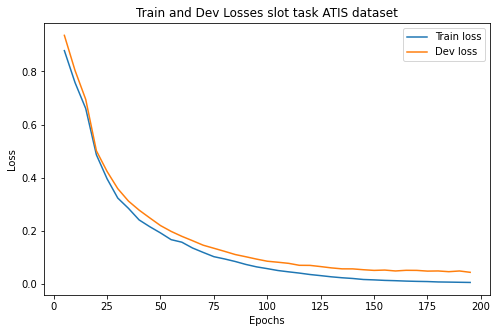

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Dev Losses slot task ATIS dataset')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epochs_ATIS, slot_losses_train_ATIS, label='Train loss')
plt.plot(sampled_epochs_ATIS, slot_losses_dev_ATIS, label='Dev loss')
plt.legend()
plt.show()

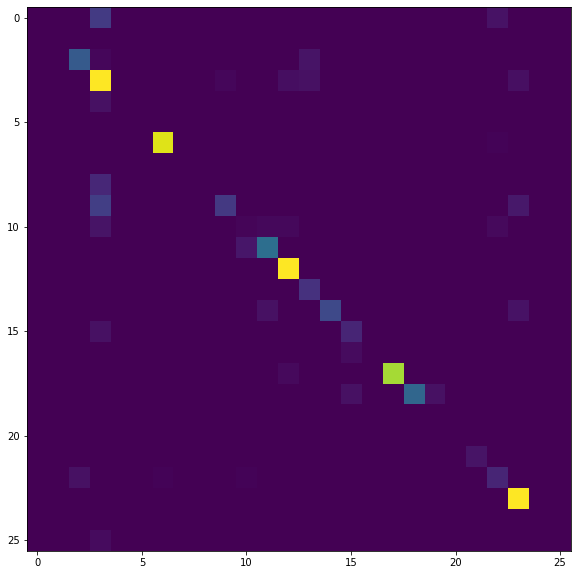

In [ ]:
mp.pyplot.figure(figsize = (10,10))
mp.pyplot.imshow(cm_intent_ATIS, norm = mp.colors.Normalize(vmin = 0, vmax = 255))

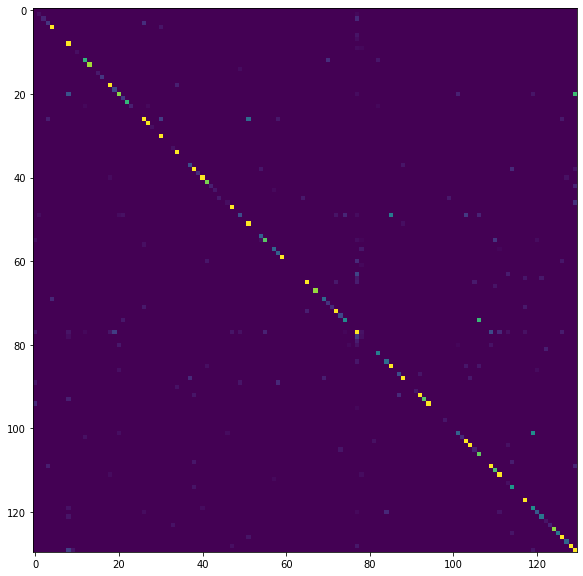

In [ ]:
mp.pyplot.figure(figsize = (10,10))
mp.pyplot.imshow(cm_slot_ATIS, norm = mp.colors.Normalize(vmin = 0, vmax = 255))

####Snips training

In [ ]:
slot_model_SNIPS.apply(init_weights)
intent_model_SNIPS.apply(init_weights)
results_test_SNIPS, intents_test_SNIPS, sampled_epochs_SNIPS, intent_losses_train_SNIPS, slot_losses_train_SNIPS, intent_losses_dev_SNIPS, slot_losses_dev_SNIPS, cm_slot_SNIPS, cm_intent_SNIPS = train_BI_model(dev_loader_SNIPS,
                                                                                                                                                                                                train_loader_SNIPS, 
                                                                                                                                                                                                test_loader_SNIPS, 
                                                                                                                                                                                                slot_model_SNIPS,
                                                                                                                                                                                                intent_model_SNIPS,
                                                                                                                                                                                                lang_SNIPS, 
                                                                                                                                                                                                criterion_intents, 
                                                                                                                                                                                                criterion_slots, 
                                                                                                                                                                                                slot_optimizer_SNIPS,
                                                                                                                                                                                                intent_optimizer_SNIPS)
print('\nSlot F1: ', round(results_test_SNIPS['total']['f-measure'],3))
print('Intent Accuracy:', round(intents_test_SNIPS['accuracy'],3))

  2%|▏         | 5/299 [03:06<3:02:38, 37.27s/it]

f1: 0
accuracy: 0.8228571428571428


  3%|▎         | 10/299 [06:10<2:59:02, 37.17s/it]

f1: 0.06962380685008422
accuracy: 0.8257142857142857


  5%|▌         | 15/299 [09:16<2:56:33, 37.30s/it]

f1: 0.4004075394803872
accuracy: 0.8357142857142857


  7%|▋         | 20/299 [12:22<2:53:30, 37.31s/it]

f1: 0.5696689761354887
accuracy: 0.8314285714285714


  8%|▊         | 25/299 [15:28<2:50:19, 37.30s/it]

f1: 0.658148631029987
accuracy: 0.8371428571428572


 10%|█         | 30/299 [18:33<2:46:16, 37.09s/it]

f1: 0.7094220110847189
accuracy: 0.8342857142857143


 12%|█▏        | 35/299 [21:37<2:42:41, 36.98s/it]

f1: 0.7448275862068965
accuracy: 0.8357142857142857


 13%|█▎        | 40/299 [24:40<2:39:12, 36.88s/it]

f1: 0.7632565613283342
accuracy: 0.8385714285714285


 15%|█▌        | 45/299 [27:43<2:35:50, 36.81s/it]

f1: 0.7954729183508489
accuracy: 0.84


 17%|█▋        | 50/299 [30:47<2:33:26, 36.97s/it]

f1: 0.8025959978366685
accuracy: 0.8371428571428572


 18%|█▊        | 55/299 [33:52<2:30:46, 37.07s/it]

f1: 0.8159392789373814
accuracy: 0.8385714285714285


 20%|██        | 60/299 [36:58<2:28:31, 37.29s/it]

f1: 0.8278467350242849
accuracy: 0.8342857142857143


 22%|██▏       | 65/299 [40:05<2:26:13, 37.49s/it]

f1: 0.8365122615803815
accuracy: 0.8371428571428572


 23%|██▎       | 70/299 [43:11<2:22:14, 37.27s/it]

f1: 0.8413905486148832
accuracy: 0.8385714285714285


 25%|██▌       | 75/299 [46:16<2:19:25, 37.35s/it]

f1: 0.8382193268186753
accuracy: 0.8371428571428572


 27%|██▋       | 80/299 [49:23<2:16:48, 37.48s/it]

f1: 0.8485178134348653
accuracy: 0.8428571428571429


 28%|██▊       | 85/299 [52:29<2:13:42, 37.49s/it]

f1: 0.8601036269430051
accuracy: 0.8371428571428572


 30%|███       | 90/299 [55:35<2:10:11, 37.38s/it]

f1: 0.8631521442228899
accuracy: 0.84


 32%|███▏      | 95/299 [58:41<2:07:16, 37.44s/it]

f1: 0.8656471873293281
accuracy: 0.8414285714285714


 33%|███▎      | 100/299 [1:01:48<2:04:10, 37.44s/it]

f1: 0.8664477285166939
accuracy: 0.8385714285714285


 35%|███▌      | 105/299 [1:04:53<2:00:19, 37.21s/it]

f1: 0.8598743512701449
accuracy: 0.8342857142857143


 37%|███▋      | 110/299 [1:08:00<1:57:47, 37.39s/it]

f1: 0.8658503401360544
accuracy: 0.8385714285714285


 38%|███▊      | 115/299 [1:11:06<1:54:29, 37.34s/it]

f1: 0.8688301063539678
accuracy: 0.8371428571428572


 40%|████      | 120/299 [1:14:14<1:52:14, 37.63s/it]

f1: 0.8771163298743856
accuracy: 0.8357142857142857


 42%|████▏     | 125/299 [1:17:19<1:48:09, 37.30s/it]

f1: 0.8796270907595284
accuracy: 0.8371428571428572


 43%|████▎     | 130/299 [1:20:24<1:44:57, 37.26s/it]

f1: 0.8855339006313478
accuracy: 0.8428571428571429


 45%|████▌     | 135/299 [1:23:30<1:41:35, 37.17s/it]

f1: 0.8886450905101481
accuracy: 0.84


 47%|████▋     | 140/299 [1:26:35<1:38:31, 37.18s/it]

f1: 0.8784227820372399
accuracy: 0.8442857142857143


 48%|████▊     | 145/299 [1:29:41<1:35:32, 37.23s/it]

f1: 0.8790544255085211
accuracy: 0.8385714285714285


 50%|█████     | 150/299 [1:32:46<1:32:19, 37.18s/it]

f1: 0.886326194398682
accuracy: 0.84


 52%|█████▏    | 155/299 [1:35:51<1:29:12, 37.17s/it]

f1: 0.8811881188118812
accuracy: 0.8428571428571429


 53%|█████▎    | 159/299 [1:38:56<1:27:07, 37.34s/it]

f1: 0.8864509051014811
accuracy: 0.8414285714285714



Slot F1:  0.871
Intent Accuracy: 0.789


In [ ]:
pd_tbl = pd.DataFrame().from_dict({k: v for k, v in sorted(results_test_SNIPS.items(), key=lambda x: x[1]['f-measure'], reverse = True)}, orient='index')
pd_tbl.round(decimals=3)

,precision,recall,f-measure,support
best_rating,1.000,1.000,1.000,43
party_size_number,1.000,1.000,1.000,50
rating_unit,1.000,1.000,1.000,40
object_location_type,1.000,1.000,1.000,22
movie_type,1.000,1.000,1.000,33
object_select,1.000,1.000,1.000,40
rating_value,1.000,0.988,0.994,80
playlist_owner,0.986,0.971,0.978,70
condition_temperature,1.000,0.957,0.978,23
sort,0.941,1.000,0.970,32


In [ ]:
intents_test_SNIPS.pop('accuracy')
pd_tbl = pd.DataFrame().from_dict({k: v for k, v in sorted(intents_test_SNIPS.items(), key=lambda x: x[1]['f1-score'], reverse = True)}, orient='index')
pd_tbl.round(decimals=3)

,precision,recall,f1-score,support
GetWeather,0.990,0.981,0.986,104
BookRestaurant,0.978,0.978,0.978,92
RateBook,0.930,1.000,0.964,80
SearchScreeningEvent,0.961,0.916,0.938,107
SearchCreativeWork,0.923,0.897,0.910,107
macro avg,0.741,0.825,0.764,700
weighted avg,0.720,0.789,0.738,700
PlayMusic,0.404,1.000,0.575,86
AddToPlaylist,0.000,0.000,0.000,124


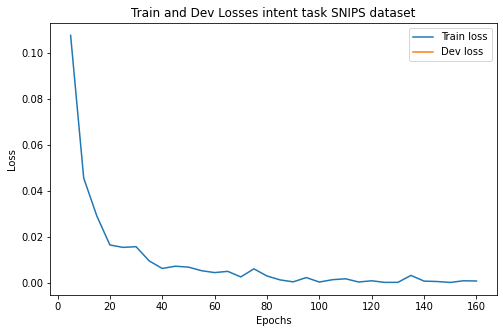

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Dev Losses intent task SNIPS dataset')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epochs_SNIPS, intent_losses_train_SNIPS, label='Train loss')
plt.plot(sampled_epochs_SNIPS, intent_losses_dev_SNIPS, label='Dev loss')
plt.legend()
plt.show()

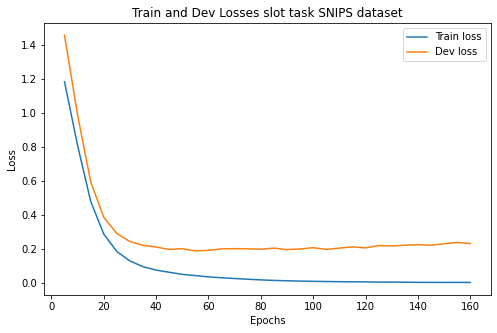

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Dev Losses slot task SNIPS dataset')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epochs_SNIPS, slot_losses_train_SNIPS, label='Train loss')
plt.plot(sampled_epochs_SNIPS, slot_losses_dev_SNIPS, label='Dev loss')
plt.legend()
plt.show()

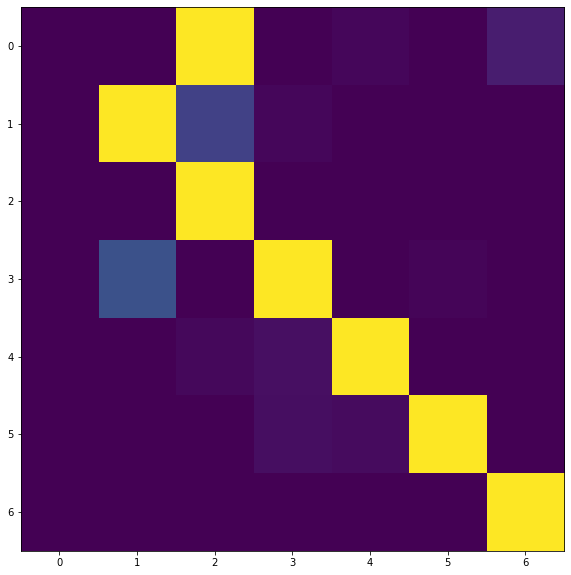

In [ ]:
mp.pyplot.figure(figsize = (10,10))
mp.pyplot.imshow(cm_intent_SNIPS, norm = mp.colors.Normalize(vmin = 0, vmax = 255))

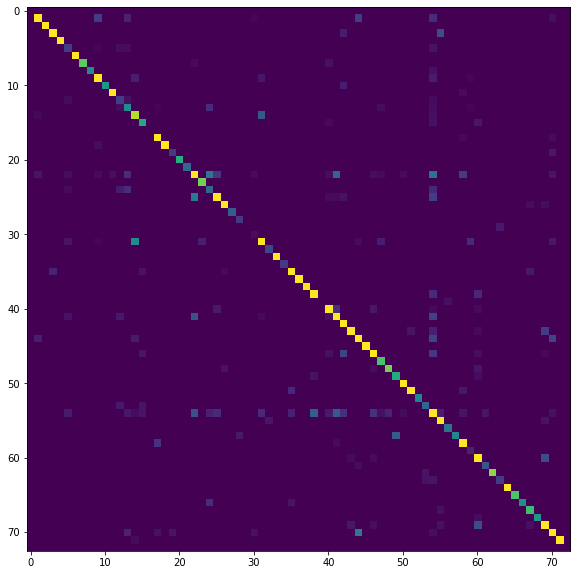

In [ ]:
mp.pyplot.figure(figsize = (10,10))
mp.pyplot.imshow(cm_slot_SNIPS, norm = mp.colors.Normalize(vmin = 0, vmax = 255))